# Statement Sentiment Analysis
---

# 1. Introduction

---

**Background**

Mental health issues such as depression, anxiety, stress, and suicidal tendencies are increasingly prevalent among individuals in various environments, including schools, workplaces, and public communities. These conditions often remain hidden due to stigma, lack of awareness, or reluctance to share personal struggles openly. Teachers, managers, or peers may find it challenging to identify individuals in distress based solely on observable behavior. However, language—the words people use in their statements or conversations—can reveal subtle indicators of mental health status. By leveraging Natural Language Processing (NLP), we can analyze such patterns and assist in early detection, enabling timely intervention and support.

**Problem Statement**

The goal of this project is to develop a system that can assist in classifying large swathes of data of an individual's mental health status based on their statements. This classification can help educators, employers, or mental health professionals gain insights into potential risks and provide appropriate assistance.

**Problem Statement Exploration**

1. What differentiates “normal” sentiment from statements that reflect mental health concerns?

2. What does the distribution of statements across each status look like?

3. Can mental health statuses be grouped into three broader levels  to simplify detection and response strategies?

4. Average word frequency for statements in each status group

5. Top 10 words for each status group

**Objectives**

1. Understand NLP concepts and their application in text classification, particularly for detecting mental health indicators from statements.

2. Prepare and preprocess textual data (cleaning, tokenization, encoding) for use in NLP models.

3. Implement an Artificial Neural Network (ANN) to classify statuses.

4. Analyze and explain the model’s performance using appropriate metrics (e.g., accuracy, F1-score, confusion matrix) and provide insights into language patterns associated with different mental health conditions.

**Dataset**

- Title : CombinedData.csv
- Source: [Click Here!](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health)

**Overview of dataset**

The dataset sourced from kaggle is a curated collection of online statements gathered from various websites (e.g., Twitter, Reddit). It contains three columns, **Unnamed: 0** that acts as an identifier, **Statement**, as the name suggests, includes individual statements on their internet accounts, and would be the X-axis in this project, and **Status** which explains the current mental state of the people based on their statements and will act as the Y-axis (target variable). 

| **Column Name**       | **Description**                                                     | **Data Range / Categories**                                                   | **Data Type**      |
| --------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------------------- | ------------------ |
| **Unnamed: 0**        | Index or identifier for each record in the dataset.                 | Unique integer values                                                         | Integer            |
| **Statement**         | Textual content of the individual’s online post or statement.       | Varies by length; free-text content from platforms like Twitter, Reddit       | String (Text)      |
| **Status** *(Target)* | Mental health status label assigned based on the statement content. | depressed, normal, bipolar, stressed, suicidal, anxiety, personality disorder | Categorical (Text) |


**Scope**

The project focuses on analyzing textual statements to classify an individual's mental health status into one of the predefined categories:
depressed, normal, bipolar, stressed, suicidal, anxiety, and personality disorder.

The primary data source is the provided dataset; the model’s accuracy and insights will depend on the quality and representativeness of this data.

The project applies Natural Language Processing (NLP) and machine learning techniques, such as text preprocessing, feature extraction, and classification algorithms (e.g., Logistic Regression, SVM, or Transformer-based models).

The analysis will also explore the possibility of grouping these statuses into three broader risk levels (Normal, Mild, High Risk) for practical application.

The system aims to assist mental health professionals and organizations by providing early detection support, not to replace human judgment or clinical diagnosis.

**Limitations**

The model’s performance depends heavily on the dataset size and diversity; results may not generalize well to unseen real-world data.

Statements are analyzed only based on text content; context such as tone, body language, or prior mental health history is not considered.

The model cannot provide a clinical diagnosis; it only predicts the likelihood of a mental health category based on language patterns.

Short, ambiguous, or sarcastic statements may lead to misclassification.

---

In [1]:
from huggingface_hub import login

login()


# 2. Import Libraries

In [2]:

# Basic utilities
import os
import re
import string
import json
import pickle
import random
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# NLP (NLTK)
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords

nltk.download('stopwords')
nltk.download('punkt')


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, Dropout,
    GlobalAveragePooling1D, Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Optional: TensorFlow Hub
import tensorflow_hub as hub

# Version check
print("TensorFlow version:", tf.__version__)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kozigous/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kozigous/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TensorFlow version: 2.15.1


---

# 3. Data Loading

In [3]:
# Read CSV file
df_raw = pd.read_csv("CombinedData.csv")
# Display the first 5 rows
print(df_raw.head())


   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [4]:
df_raw.info()
df_raw.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Unnamed: 0    53043
statement     51073
status            7
dtype: int64

# 4. Preprocessing Before EDA

Before conducting Exploratory Data Analysis (EDA), it is essential to perform basic preprocessing to ensure the dataset is clean and ready for analysis. The following steps were taken:

1. Handling Missing Values: The statement column contained some missing values, which were replaced with an empty string to avoid errors during text processing, as models cannot handle NaN values.

2. Dropping Identifier: The unique_id column was removed since it serves only as an identifier and provides no predictive value.

These steps help maintain data integrity and prepare the text for tokenization, vectorization, and feature extraction.

---
**Handling Missing Values**

In this part we will do a customary missingness check to handle if there are any. Considerations for doing this early on are:

- Data Integrity: Missing values can lead to inconsistencies in preprocessing (e.g., tokenization or vectorization errors).

- Model Readiness: Many algorithms cannot handle NaN values, so imputing or addressing them early prevents downstream issues.

- Bias Prevention: Missing data may be concentrated in specific classes, introducing bias if not handled properly.

- Feature Engineering Impact: Text-based features like TF-IDF or embeddings require complete data to generate meaningful vectors.

In [5]:
df_raw.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [6]:
rows_with_missing = df_raw[df_raw.isnull().any(axis=1)]
print(rows_with_missing)

       Unnamed: 0 statement   status
293           293       NaN  Anxiety
572           572       NaN  Anxiety
595           595       NaN  Anxiety
1539         1539       NaN   Normal
2448         2448       NaN   Normal
...           ...       ...      ...
52838       52838       NaN  Anxiety
52870       52870       NaN  Anxiety
52936       52936       NaN  Anxiety
53010       53010       NaN  Anxiety
53031       53031       NaN  Anxiety

[362 rows x 3 columns]


In [7]:
missing_by_status = df_raw[df_raw.isnull().any(axis=1)].groupby('status').size()
print(missing_by_status)

status
Anxiety                  47
Bipolar                 100
Normal                    8
Personality disorder    124
Stress                   82
Suicidal                  1
dtype: int64


Decision: Missing values will not be imputed normally; instead, they will be filled with a blank statement represented as [unknown] for the following reasons:

In NLP, imputing text data is generally not recommended because it can introduce bias and distort the semantic meaning of the text.

Common imputation strategies (e.g., filling with placeholders or frequent tokens) may negatively affect model performance.

References:

[How do you handle missing data in NLP tasks?](https://milvus.io/ai-quick-reference/how-do-you-handle-missing-data-in-nlp-tasks)

[How to impute missing text data?](https://datascience.stackexchange.com/questions/99545/how-to-impute-missing-text-data)


In [8]:
# Replace missing values in the 'statement' column with an empty string
# new copy as to keep the original dataset intact 
df = df_raw.copy()

df['statement'] = df['statement'].fillna('')

# Verify if there are any remaining missing values in the dataset
missing_rows = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values: {missing_rows.shape[0]}")

Number of rows with missing values: 0


In [9]:
# Check the percentage of empty strings in the 'statement' column after imputation
col = 'statement'
empty_percentage = (df[col].str.strip().eq('').sum() / len(df)) * 100
print(f"Percentage of empty statements in '{col}': {empty_percentage:.2f}%")


Percentage of empty statements in 'statement': 0.68%


Empty statement token showing up in 0.68% of the dataset is relatively small and usually won’t cause major problems, but with some caveats:

- Minimal Semantic Value: Blank statements provide no information, so models can’t extract meaningful features.

- Class Bias Risk: Blanks are unevenly distributed across classes (e.g., Personality Disorder, Bipolar), which might create slight bias.

- Default Predictions: For blanks, models will likely default to the majority class since there’s no signal.

- Impact is Negligible: At only 0.68%, the effect on performance is minimal, so blanks were retained to preserve dataset size. Models like TF-IDF and BERT can handle them without issues.

Final statement: 

[Nan] tokens were replaced with blanks to maintain text consistency and avoid introducing artificial tokens that do not exist in natural language. This prevents misleading the model during feature extraction or tokenization. Blank entries were retained as they represent genuine cases of missing or uninformative text.

Blank statements (0.68% of data) were retained because their proportion is negligible and removing them would not significantly improve data quality

---

**Dropping Unnamed: 0 (Variable Identifier)**

This column serves only as a unique identifier for each record and carries no predictive or semantic information relevant to the target (status). Keeping it could introduce unnecessary noise without adding value to the model, so it is dropped.

In [10]:
# Drop the identifier column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Verify the column is removed
print(df)

                                               statement   status
0                                             oh my gosh  Anxiety
1      trouble sleeping, confused mind, restless hear...  Anxiety
2      All wrong, back off dear, forward doubt. Stay ...  Anxiety
3      I've shifted my focus to something else but I'...  Anxiety
4      I'm restless and restless, it's been a month n...  Anxiety
...                                                  ...      ...
53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040  Is there any way to sleep better? I can't slee...  Anxiety
53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 2 columns]


---

**Stopword Removal**

Stopword removal will be delayed until the first exploratory data analysis (EDA) for the following reasons:

Understand term frequency distribution: Removing stopwords too early can hide insights about common word patterns across different mental health statuses.

Identify meaningful stopwords: Some words considered stopwords in general NLP may carry significance in this dataset (e.g., "not", "no").

Preserve raw text for initial analysis: EDA requires the original text structure to detect trends, anomalies, and patterns accurately.

Better-informed preprocessing decisions: Analyzing raw data first ensures that any stopword removal is justified and does not remove context-critical terms.

---

# 4. Exploratory Data Analysis (EDA)

## 4.1 - Top 10 words for each status group


=== RAW TEXT ANALYSIS (NO STOPWORDS REMOVED) ===


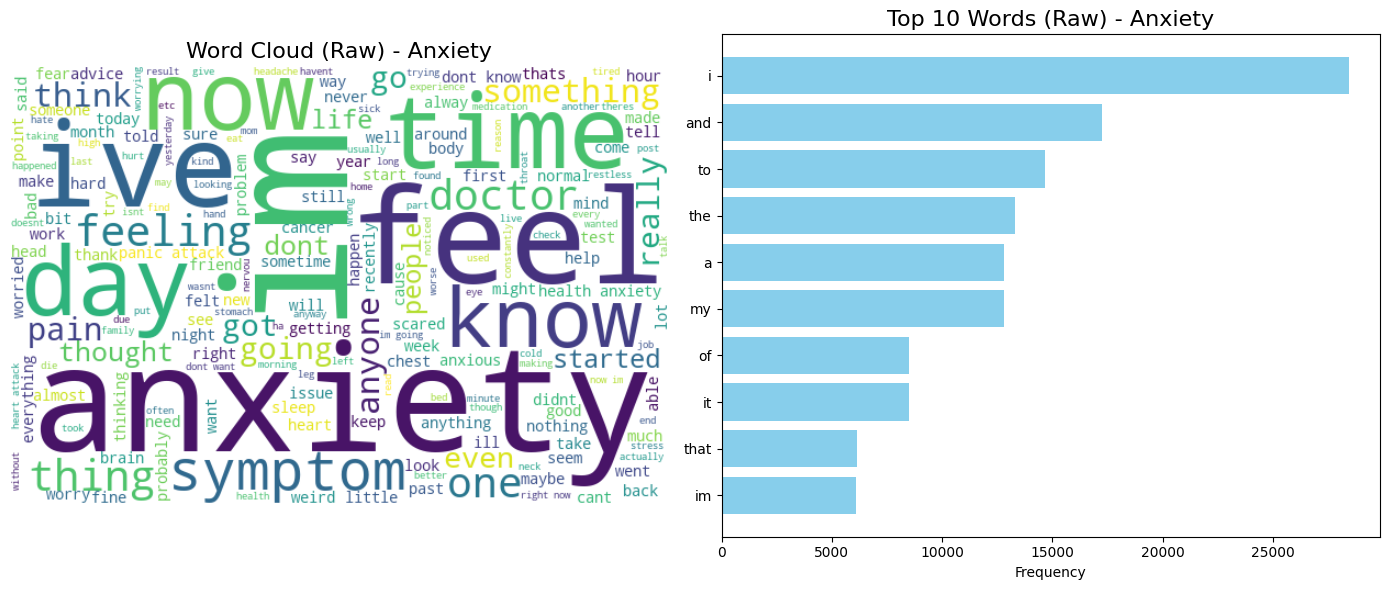

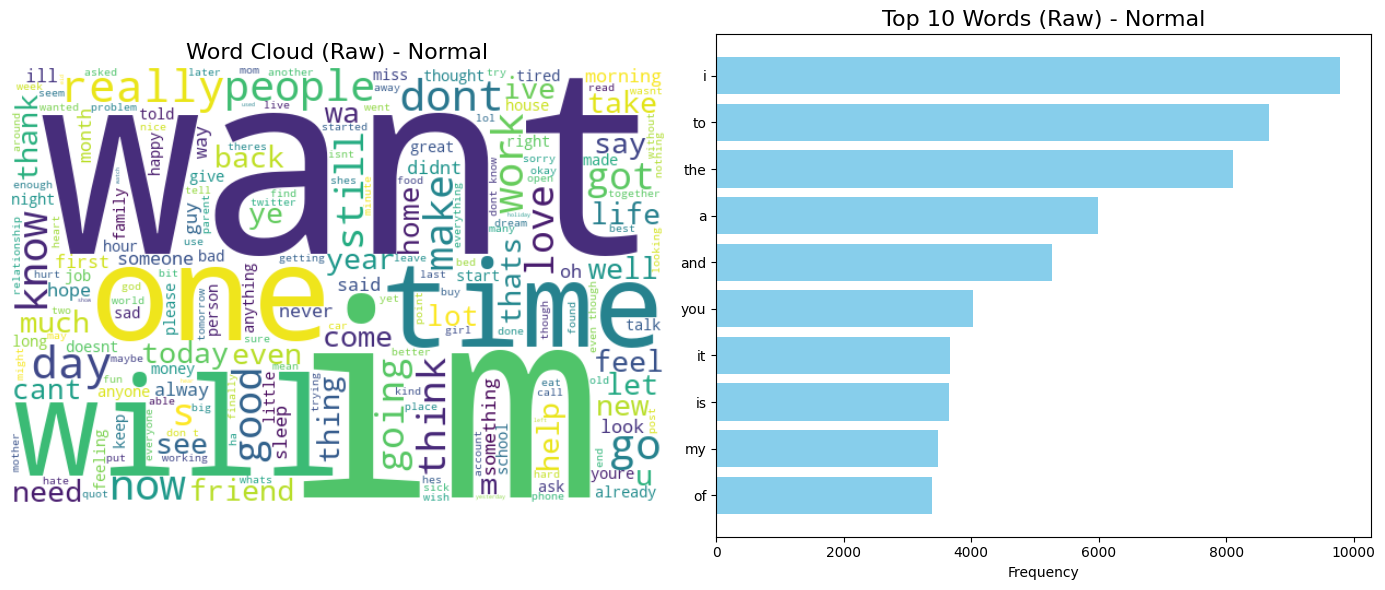

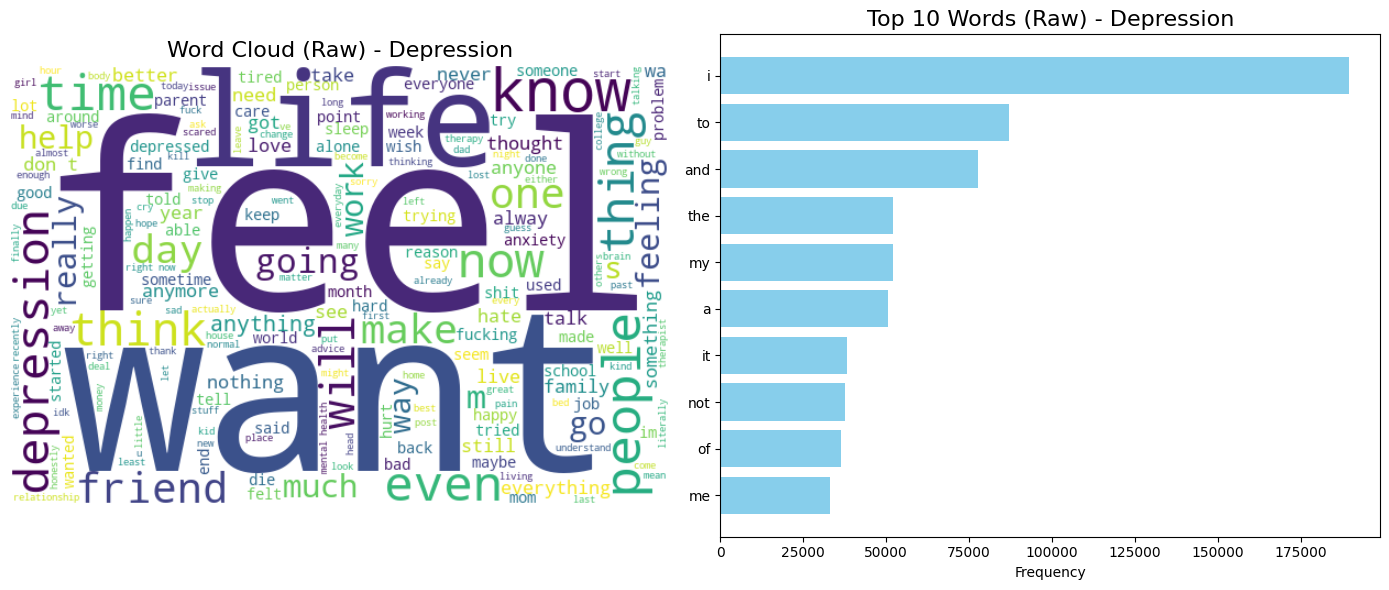

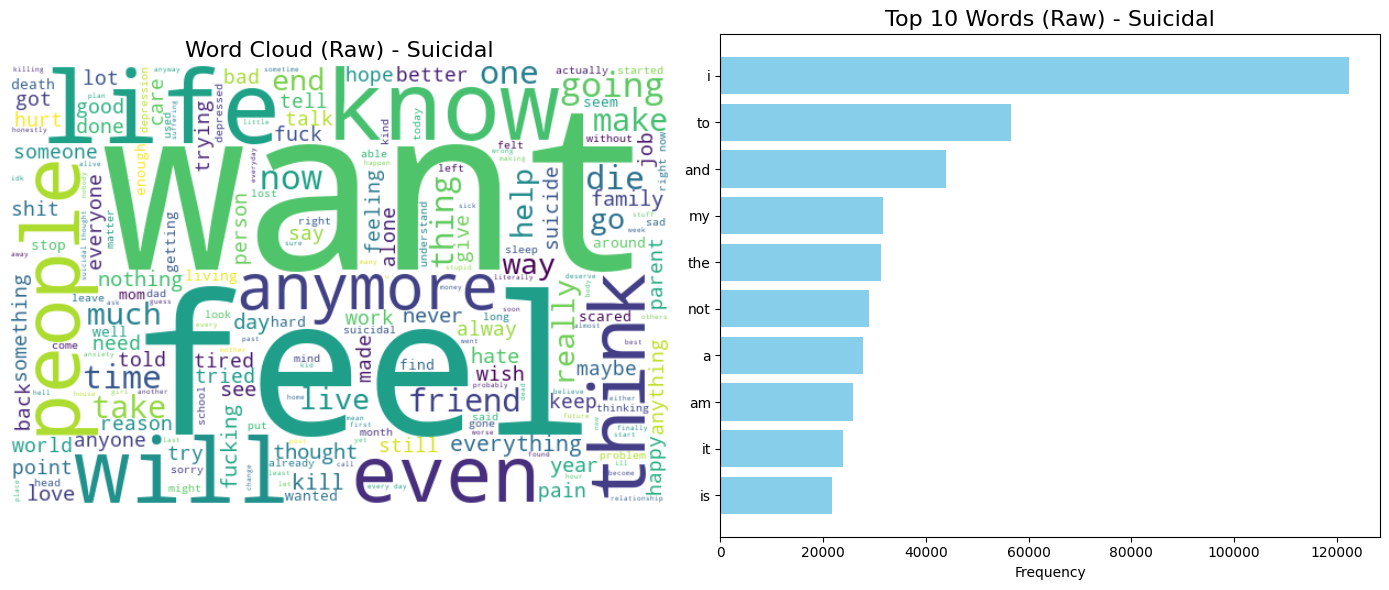

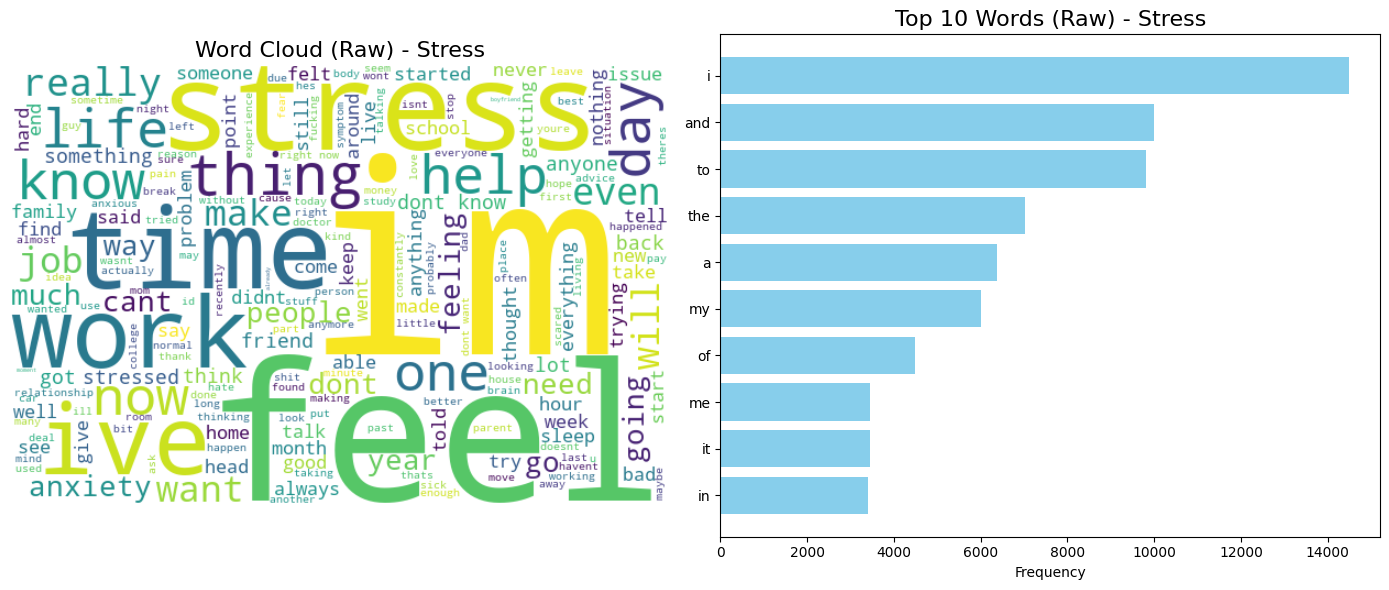

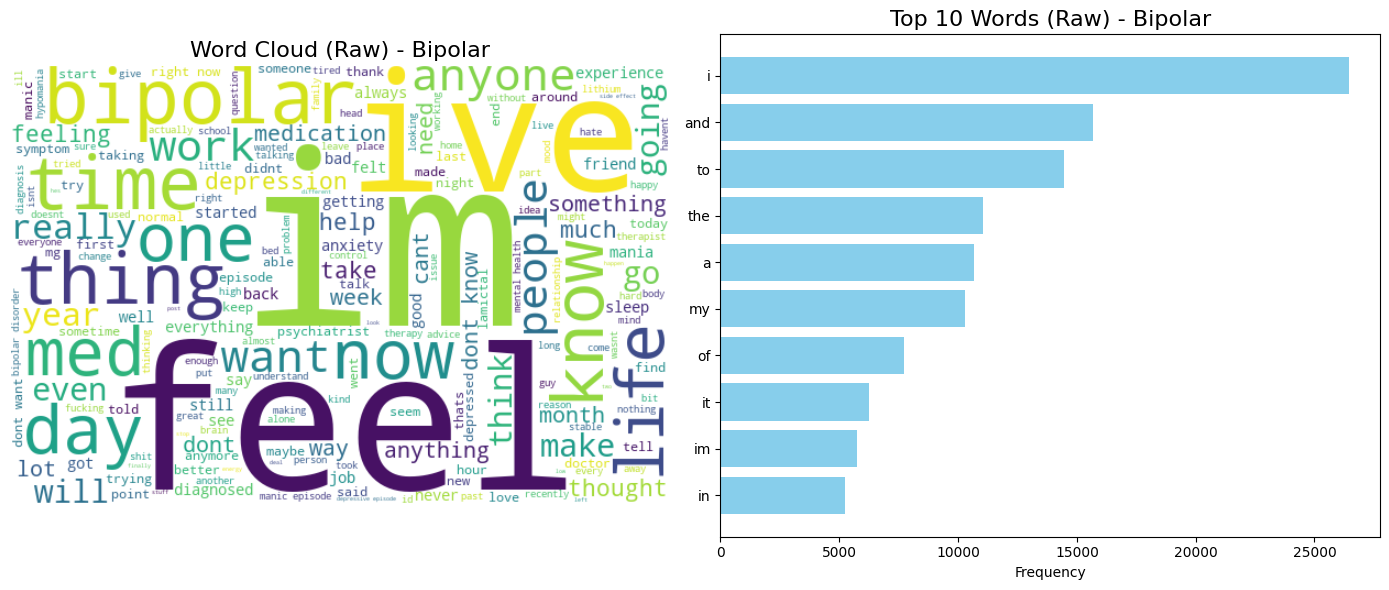

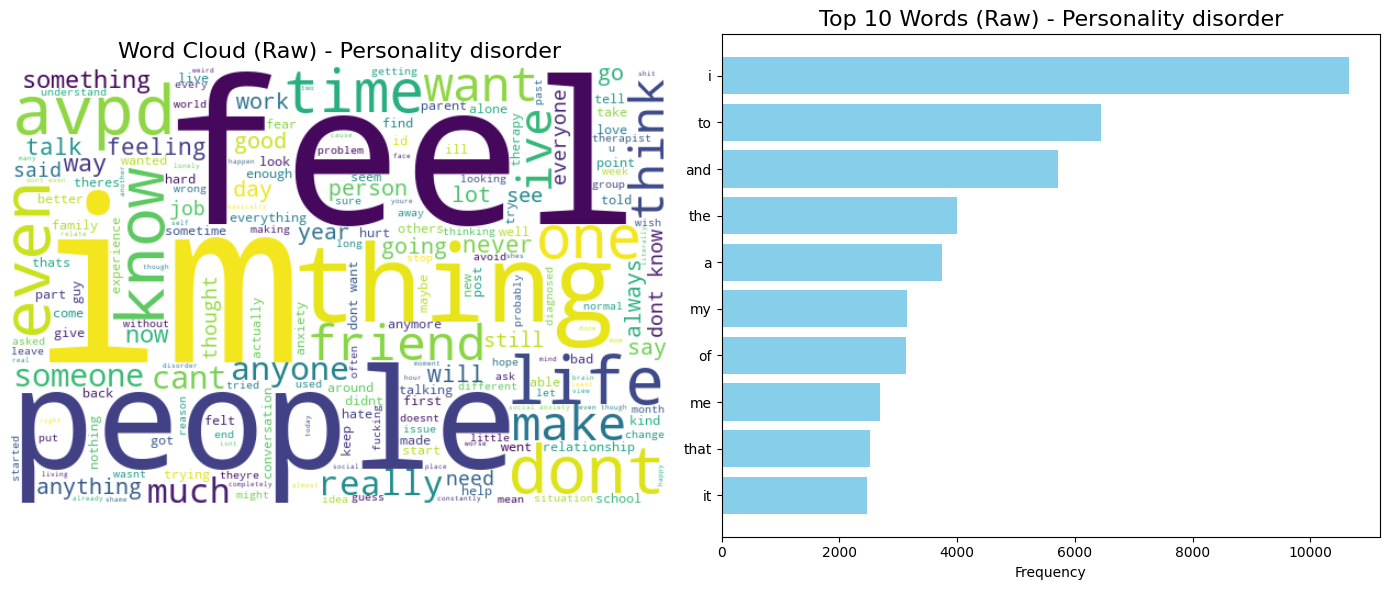


=== SUMMARY OF TOP WORDS PER STATUS (RAW) ===
Anxiety: [('i', 28435), ('and', 17271), ('to', 14649), ('the', 13324), ('a', 12810), ('my', 12787), ('of', 8521), ('it', 8491), ('that', 6131), ('im', 6092)]
Normal: [('i', 9781), ('to', 8675), ('the', 8108), ('a', 5987), ('and', 5267), ('you', 4026), ('it', 3674), ('is', 3647), ('my', 3476), ('of', 3388)]
Depression: [('i', 189494), ('to', 86902), ('and', 77597), ('the', 52071), ('my', 52066), ('a', 50392), ('it', 38085), ('not', 37685), ('of', 36415), ('me', 32898)]
Suicidal: [('i', 122281), ('to', 56487), ('and', 43987), ('my', 31694), ('the', 31193), ('not', 28989), ('a', 27770), ('am', 25720), ('it', 23914), ('is', 21708)]
Stress: [('i', 14481), ('and', 9995), ('to', 9821), ('the', 7012), ('a', 6376), ('my', 6004), ('of', 4474), ('me', 3454), ('it', 3447), ('in', 3396)]
Bipolar: [('i', 26435), ('and', 15668), ('to', 14476), ('the', 11055), ('a', 10678), ('my', 10286), ('of', 7713), ('it', 6249), ('im', 5732), ('in', 5257)]
Personality

In [11]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Check required columns
if not {"statement", "status"}.issubset(df.columns):
    raise ValueError("Dataset must include both 'statement' (text) and 'status' columns.")

# Define text cleaning function
def clean_text(text):
    text = text.lower()                          # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)        # Remove special characters/numbers
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces
    return text

# Define statuses of interest
statuses = ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']

print("\n=== RAW TEXT ANALYSIS (NO STOPWORDS REMOVED) ===")
raw_summary = {}

for status in statuses:
    subset = df[df['status'] == status]
    if subset.empty:
        print(f"[INFO] No data for status: {status}")
        continue
    
    text = " ".join(clean_text(txt) for txt in subset['statement'] if pd.notnull(txt))
    words = text.split()
    
    if not words:
        print(f"[WARNING] No valid words found for {status}.")
        continue
    
    # Count top 10 words
    word_counts = Counter(words)
    common_words = word_counts.most_common(10)
    raw_summary[status] = common_words
    
    # Word Cloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        background_color="white",
        max_words=200,
        colormap="viridis"
    ).generate(" ".join(words))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(wordcloud, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Word Cloud (Raw) - {status}", fontsize=16)
    
    words_, counts_ = zip(*common_words) if common_words else ([], [])
    axes[1].barh(words_, counts_, color="skyblue")
    axes[1].invert_yaxis()
    axes[1].set_title(f"Top 10 Words (Raw) - {status}", fontsize=16)
    axes[1].set_xlabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Print summary
print("\n=== SUMMARY OF TOP WORDS PER STATUS (RAW) ===")
for status, words in raw_summary.items():
    print(f"{status}: {words}")



**Stopword Removal**

To improve the quality of text data, we apply **stopword removal**. Stopwords are commonly used words that do not contribute significant meaning to the text, such as conjunctions, prepositions, and pronouns. Removing these helps reduce noise and highlight more meaningful terms.

**Custom Stopword List**

In addition to standard English stopwords, we include domain-specific additions based on frequency analysis of our dataset:

```
["i", "im", "ive", "my", "me", "you", "and", "to", "the", "a", "of", "it",
 "is", "in", "that", "am", "not", "cant", "dont", "for", "on", "at"]
```

**Reason:** These words were found to dominate the top frequency counts across all statuses, offering little discriminative power for classification or analysis.



**Handling Contractions and Pronouns**

* **Contractions** (e.g., *I'm*, *I've*, *don't*) are normalized during preprocessing.

  * Example: *I'm* → *im*, *don't* → *dont*
* **Pronouns** (e.g., *I*, *me*, *you*) appear frequently in statements but do not add meaningful context for distinguishing between mental health statuses.
* Both contractions and pronouns are removed as part of the extended stopword list to reduce noise and improve model performance.



=== CLEANED TEXT ANALYSIS (STOPWORDS REMOVED) ===


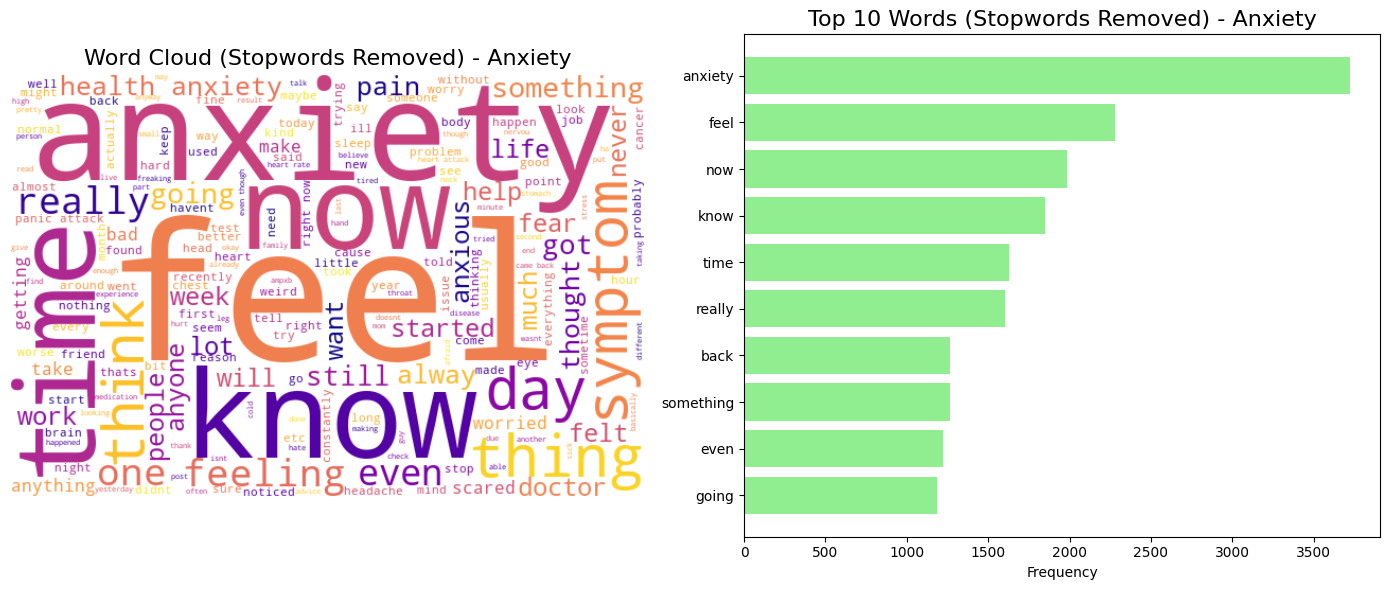

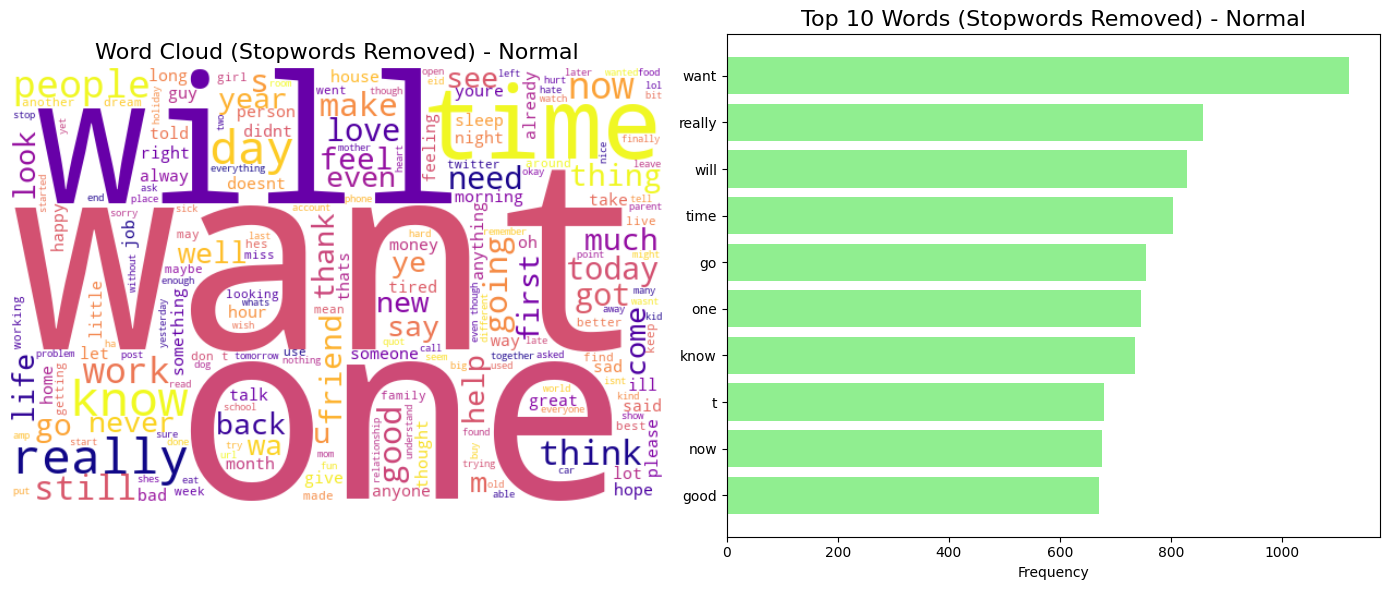

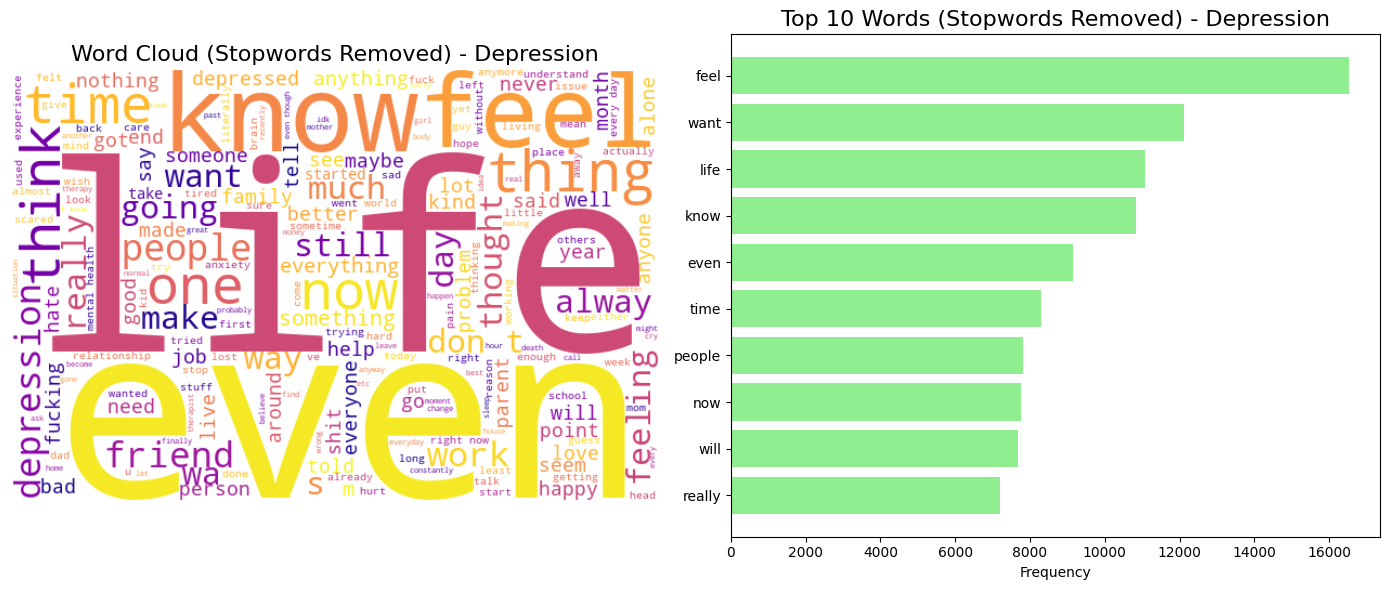

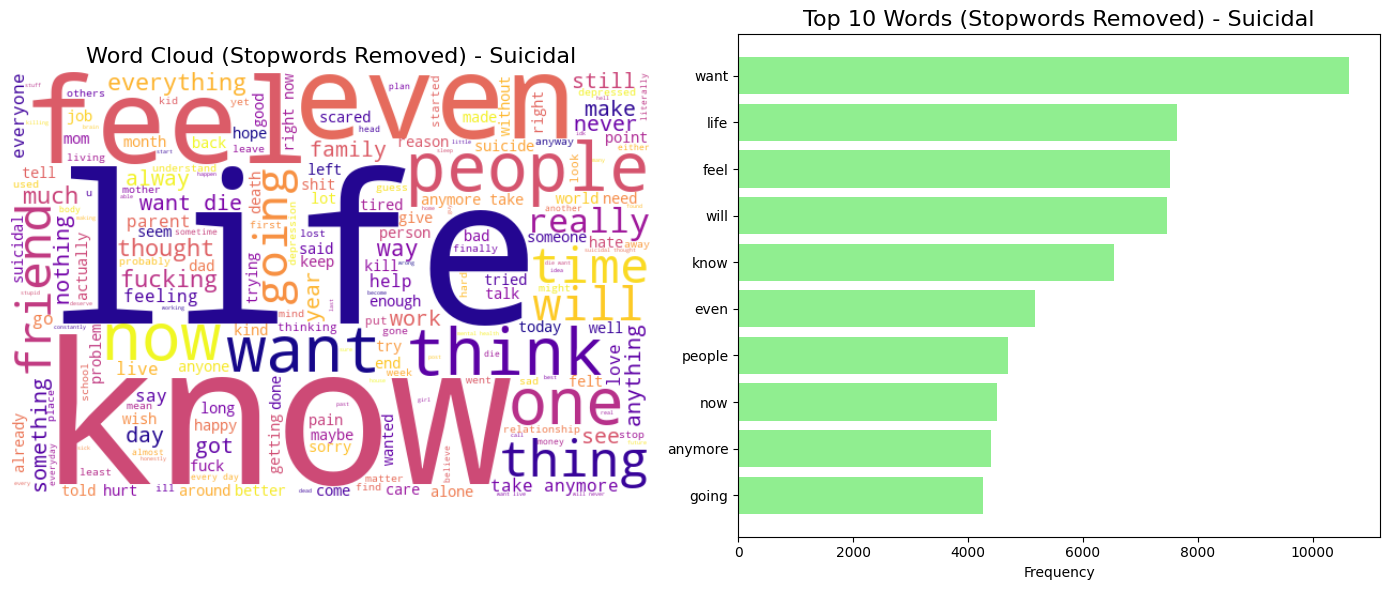

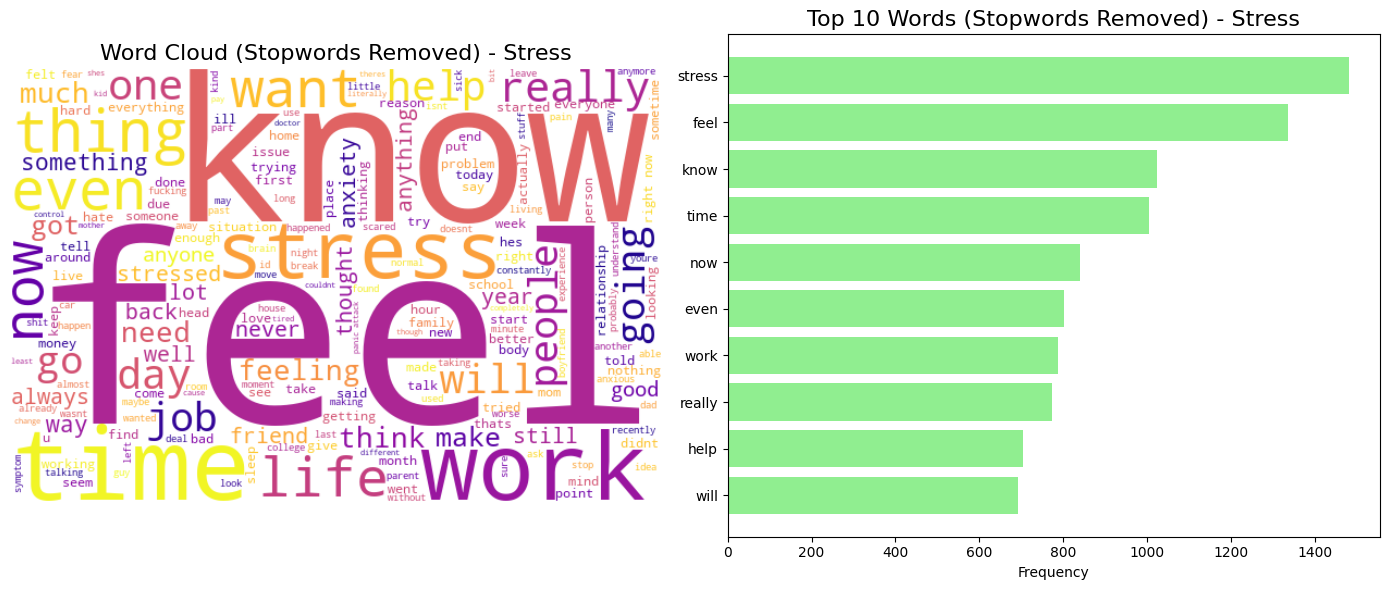

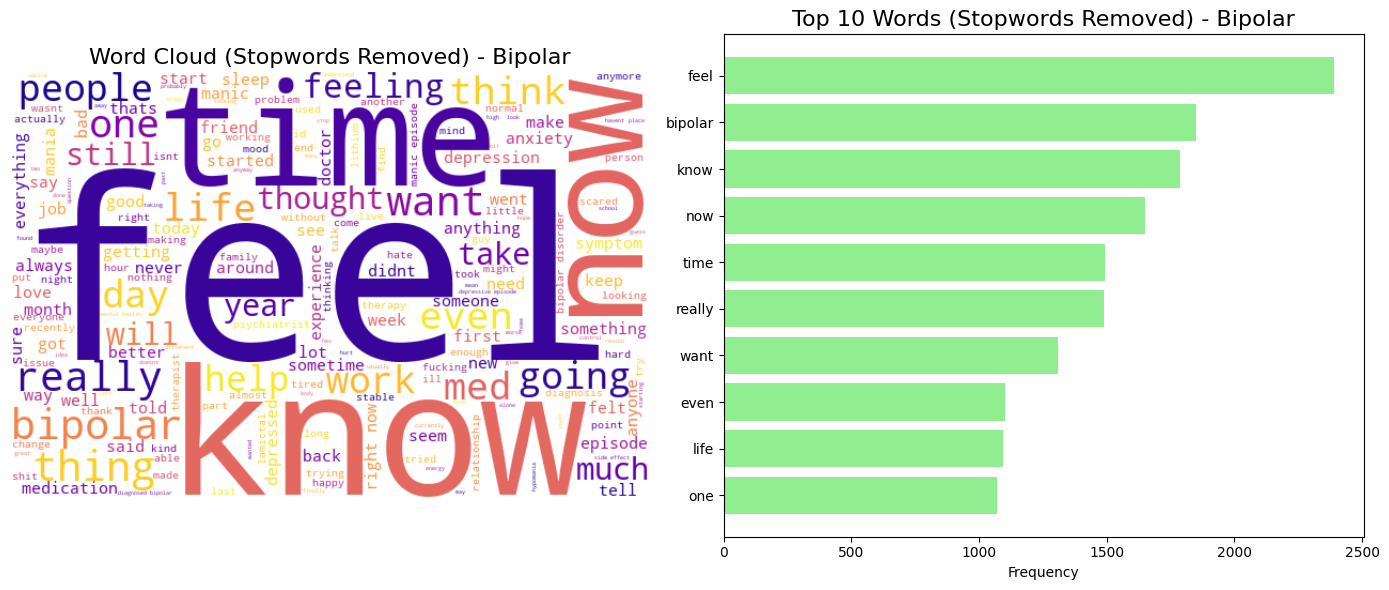

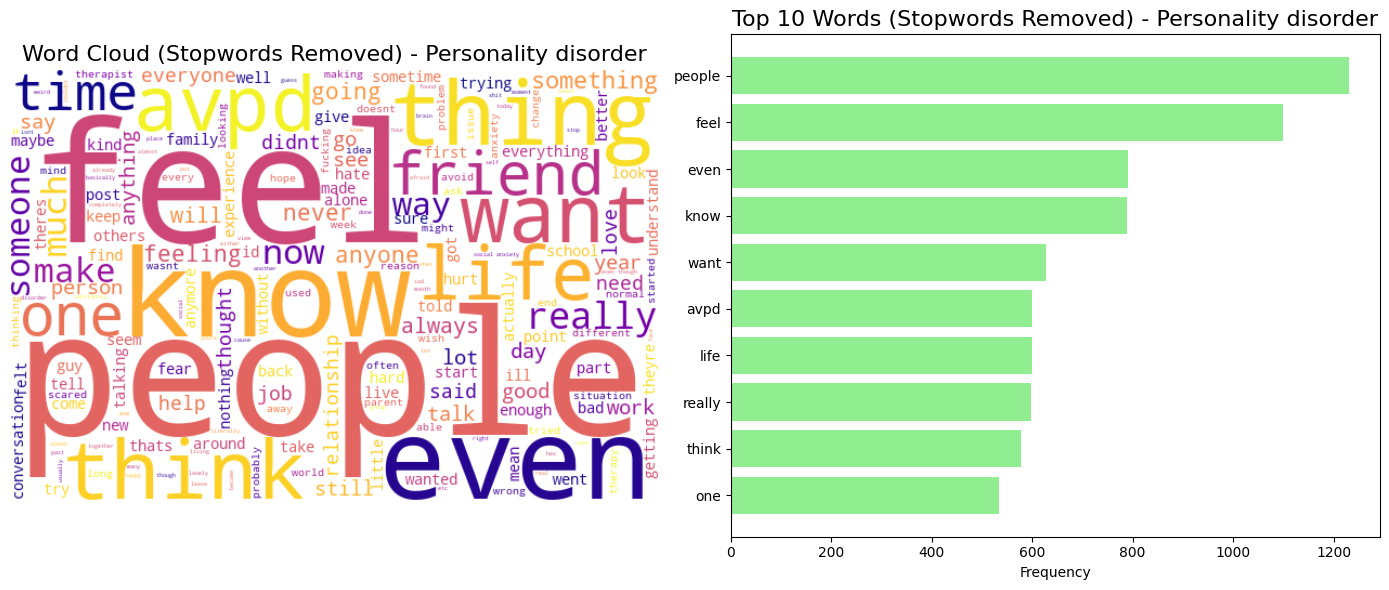


=== SUMMARY OF TOP WORDS PER STATUS (STOPWORDS REMOVED) ===
Anxiety: [('anxiety', 3721), ('feel', 2282), ('now', 1986), ('know', 1851), ('time', 1626), ('really', 1603), ('back', 1265), ('something', 1265), ('even', 1220), ('going', 1188)]
Normal: [('want', 1121), ('really', 859), ('will', 829), ('time', 805), ('go', 756), ('one', 747), ('know', 735), ('t', 679), ('now', 677), ('good', 670)]
Depression: [('feel', 16532), ('want', 12117), ('life', 11078), ('know', 10822), ('even', 9149), ('time', 8301), ('people', 7823), ('now', 7768), ('will', 7675), ('really', 7199)]
Suicidal: [('want', 10637), ('life', 7635), ('feel', 7517), ('will', 7455), ('know', 6535), ('even', 5170), ('people', 4688), ('now', 4504), ('anymore', 4401), ('going', 4267)]
Stress: [('stress', 1482), ('feel', 1337), ('know', 1023), ('time', 1005), ('now', 841), ('even', 803), ('work', 789), ('really', 773), ('help', 705), ('will', 692)]
Bipolar: [('feel', 2389), ('bipolar', 1851), ('know', 1787), ('now', 1652), ('tim

In [12]:
# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "i", "im", "ive", "my", "me", "you", "and", "to", "the", "a", "of", "it",
    "is", "in", "that", "am", "not", "cant", "dont", "for", "on", "at"
])

# Clean text function (optimized)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

print("\n=== CLEANED TEXT ANALYSIS (STOPWORDS REMOVED) ===")
statuses = df['status'].unique()  # assuming df is your dataframe
cleaned_summary = {}

for status in statuses:
    subset = df[df['status'] == status]
    if subset.empty:
        continue
    
    words = []
    for txt in subset['statement']:
        if pd.notnull(txt):
            cleaned = clean_text(txt)
            words.extend([w for w in cleaned.split() if w not in custom_stopwords])
    
    if not words:
        continue
    
    # Count top 10 words
    word_counts = Counter(words)
    common_words = word_counts.most_common(10)
    cleaned_summary[status] = common_words
    
    # Word Cloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        background_color="white",
        max_words=200,
        colormap="plasma"
    ).generate(" ".join(words))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(wordcloud, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Word Cloud (Stopwords Removed) - {status}", fontsize=16)
    
    words_, counts_ = zip(*common_words) if common_words else ([], [])
    axes[1].barh(words_, counts_, color="lightgreen")
    axes[1].invert_yaxis()
    axes[1].set_title(f"Top 10 Words (Stopwords Removed) - {status}", fontsize=16)
    axes[1].set_xlabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Print summary
print("\n=== SUMMARY OF TOP WORDS PER STATUS (STOPWORDS REMOVED) ===")
for status, words in cleaned_summary.items():
    print(f"{status}: {words}")


**Interpretation of Top Words per Status (Stopwords Removed)**

1. **Anxiety**

   * Dominant word: **“anxiety”** (3721) → Indicates strong self-identification with anxiety.
   * Other frequent words: **“feel,” “now,” “know,” “time”** → Suggest people often express current emotional state and uncertainty.
   * Insight: Anxiety-related posts are focused on **immediate feelings and situational awareness**.

2. **Normal**

   * Common words: **“want,” “really,” “will,” “time,” “go”** → Neutral, goal-oriented language.
   * Insight: Normal status users talk about **future plans, desires, and everyday actions** rather than emotions.

3. **Depression**

   * Dominant words: **“feel” (16k), “want,” “life,” “know,” “even”** → Highly emotion-centric vocabulary.
   * Insight: Depression-related posts express **intense emotional states and existential concerns**.

4. **Suicidal**

   * Frequent words: **“want,” “life,” “feel,” “will,” “anymore”** → Suggests **loss of hope and strong intent-oriented expressions**.
   * Notable word: **“anymore” (4401)** → Indicates **despair and giving up** themes.
   * Insight: Suicidal group has strong forward-looking language tied to **ending life and hopelessness**.

5. **Stress**

   * Top words: **“stress,” “feel,” “work,” “help”** → Emphasizes **workload pressure and need for support**.
   * Insight: Stress language is **problem-focused and situational**, unlike depression which is more existential.

6. **Bipolar**

   * Dominant words: **“bipolar,” “feel,” “know,” “time,” “life”** → Indicates **fluctuating moods and self-awareness**.
   * Insight: Bipolar-related posts often **mention condition explicitly** and show patterns of instability.

7. **Personality Disorder**

   * Frequent words: **“people,” “feel,” “avpd,” “life,” “think”** → AVPD (Avoidant Personality Disorder) specifically noted.
   * Insight: Language focuses on **social interaction struggles and self-perception issues**.



**Overall Observations**

* **“Feel”** appears in almost every category except Normal → Emotional state is central to mental health conditions.
* **Existential words like “life,” “anymore”** dominate Depression and Suicidal → Signals critical states needing intervention.
* **Anxiety vs Stress**: Both use “feel” and “time,” but **Stress mentions “work” and “help”**, whereas Anxiety focuses on internal feelings.
* **Normal** cluster uses **neutral, future-oriented language**, very different from others.

---


In [13]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
stopwords.update([
    "i", "im", "ive", "my", "me", "you", "and", "to", "the", "a", "of", "it",
    "is", "in", "that", "am", "not", "cant", "dont", "for", "on", "at"
])

def remove_stopwords(text):
    if pd.isnull(text):
        return ""
    cleaned = clean_text(text)
    words = [w for w in cleaned.split() if w not in stopwords]
    return " ".join(words)

# Apply to eda dataframe for temporary
temp_df_cleaned = df.copy()
temp_df_cleaned['statement_clean'] = temp_df_cleaned['statement'].apply(remove_stopwords)


## 4.2 - What differentiates “normal” sentiment from statements that reflect mental health concerns?


=== TOP WORDS THAT DIFFERENTIATE NORMAL vs MENTAL HEALTH ===
             word  normal_ratio  mh_ratio      diff
31358        feel      0.003077  0.012640 -0.009563
37893        life      0.002236  0.008868 -0.006632
24042        know      0.005152  0.009253 -0.004101
20945        even      0.003337  0.007399 -0.004062
60169  depression      0.000259  0.003471 -0.003212
43124     anymore      0.000715  0.003778 -0.003063
10073     anxiety      0.000736  0.003710 -0.002974
53757        want      0.007858  0.010619 -0.002761
27183       never      0.002208  0.004646 -0.002438
8366      fucking      0.000196  0.002489 -0.002292
73978         now      0.004746  0.006982 -0.002237
48909      things      0.001647  0.003883 -0.002235
22164  everything      0.001094  0.003250 -0.002157
43352      people      0.004311  0.006457 -0.002146
67484    anything      0.001423  0.003548 -0.002125
63801         die      0.000266  0.002369 -0.002103
19113     feeling      0.001171  0.003259 -0.002088
26

/var/folders/9d/f5c8zl0904g9jptgj26v7x8m0000gn/T/ipykernel_15748/1295530508.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff', y='word', data=temp_df_diff, palette='coolwarm')


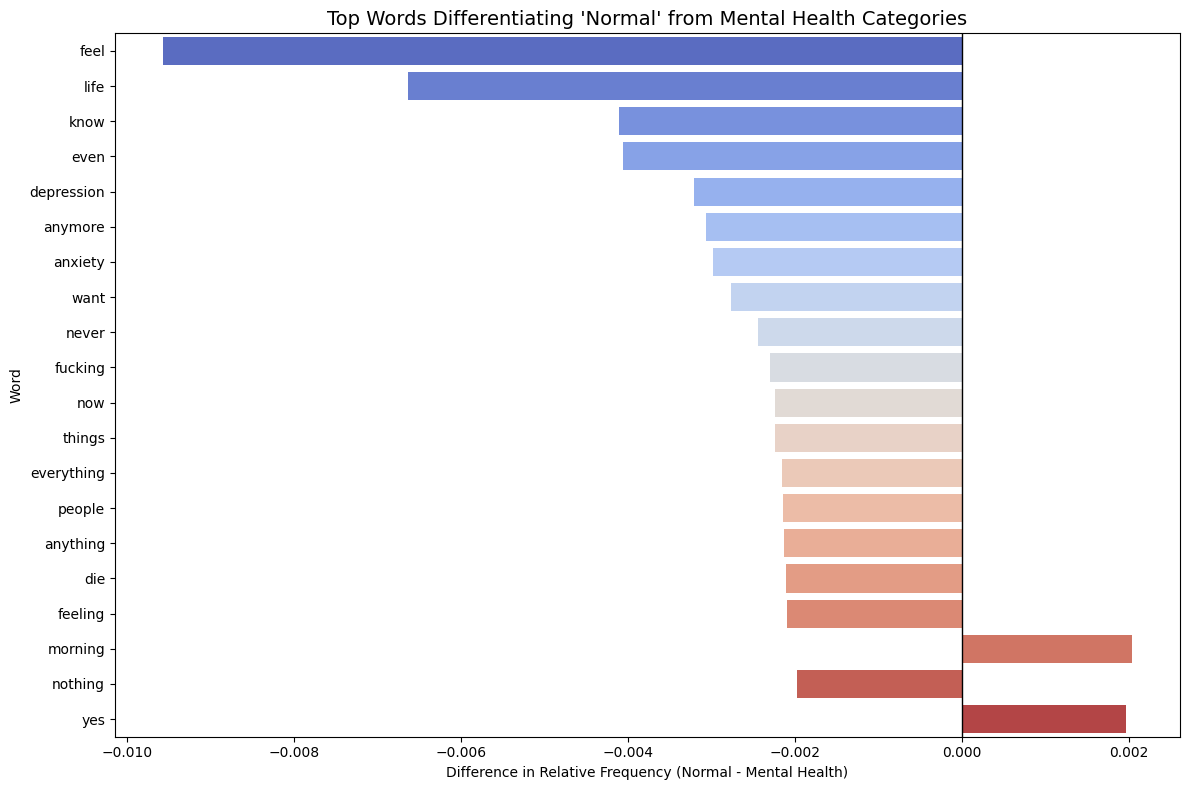

In [14]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separate Normal and Mental Health groups
normal_texts = temp_df_cleaned[temp_df_cleaned['status'] == 'Normal']['statement_clean'].dropna()
mh_texts = temp_df_cleaned[temp_df_cleaned['status'] != 'Normal']['statement_clean'].dropna()

# 2. Tokenize (stopwords already removed in 'statement_clean')
def tokenize(texts):
    words = []
    for txt in texts:
        words.extend(txt.split())  # already cleaned and stopwords removed
    return words

normal_words = tokenize(normal_texts)
mh_words = tokenize(mh_texts)

# 3. Count word frequencies
normal_counts = Counter(normal_words)
mh_counts = Counter(mh_words)

# 4. Combine frequencies into a comparison DataFrame
all_words = set(normal_counts.keys()).union(set(mh_counts.keys()))
comparison = []

for word in all_words:
    comparison.append({
        'word': word,
        'normal_freq': normal_counts[word],
        'mh_freq': mh_counts[word]
    })

temp_df_comp = pd.DataFrame(comparison)

# 5. Calculate relative importance
temp_df_comp['normal_ratio'] = temp_df_comp['normal_freq'] / temp_df_comp['normal_freq'].sum()
temp_df_comp['mh_ratio'] = temp_df_comp['mh_freq'] / temp_df_comp['mh_freq'].sum()
temp_df_comp['diff'] = temp_df_comp['normal_ratio'] - temp_df_comp['mh_ratio']

# 6. Sort by absolute difference and pick top 20
temp_df_diff = temp_df_comp.sort_values('diff', key=abs, ascending=False).head(20)

# 7. Print top differentiating words
print("\n=== TOP WORDS THAT DIFFERENTIATE NORMAL vs MENTAL HEALTH ===")
print(temp_df_diff[['word', 'normal_ratio', 'mh_ratio', 'diff']])

# 8. Visualization: Diverging Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(x='diff', y='word', data=temp_df_diff, palette='coolwarm')
plt.axvline(0, color='black', linewidth=1)
plt.title("Top Words Differentiating 'Normal' from Mental Health Categories", fontsize=14)
plt.xlabel("Difference in Relative Frequency (Normal - Mental Health)")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


**Interpretation of Top Words Differentiating Normal vs Mental Health**

1. **Words more frequent in Mental Health statements (negative `diff`)**

   * **feel (-0.0096), life (-0.0066), know (-0.0041), even (-0.0041), depression (-0.0032), anymore (-0.0031), anxiety (-0.0030), want (-0.0028), never (-0.0024), fucking (-0.0023), now (-0.0022), things (-0.0022), everything (-0.0022), people (-0.0021), anything (-0.0021), die (-0.0021), feeling (-0.0021), nothing (-0.00197)**
     **Interpretation:**
   * These words are more common in statements reflecting mental health concerns.
   * Many reflect **emotional states** (“feel”, “feeling”), **existential or life-focused thoughts** (“life”, “die”, “everything”), and **mental health terminology** (“depression”, “anxiety”).
   * Words like “anymore”, “never”, “nothing” indicate **negative sentiment and hopelessness**.
   * Expletives like “fucking” suggest **strong emotional expression**.

2. **Words more frequent in Normal statements (positive `diff`)**

   * **morning (+0.0020), yes (+0.0019)**
     **Interpretation:**
   * These words appear more in normal sentiment statements.
   * They reflect **routine, positive, or everyday interactions** rather than emotional distress.
   * The differences are smaller, indicating that normal statements are generally less emotionally charged and more neutral.



**Overall Insight**

* **Mental health statements** are characterized by **emotion-laden, negative, or condition-specific words**.
* **Normal statements** tend to focus on **everyday life, greetings, or neutral words**.

---

## 4.3 - What does the distribution of statement from each statuses look like?

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


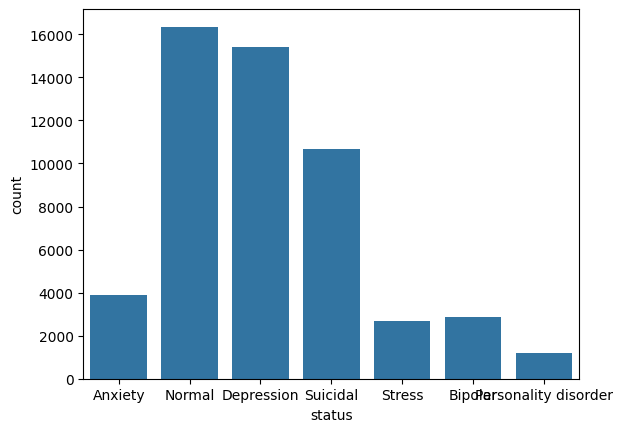

In [15]:
import seaborn as sns
sns.countplot(x='status', data=temp_df_cleaned)
print(temp_df_cleaned['status'].value_counts())

The graph shows a significant imbalance between categories. Most notably, the statuses 'Normal', 'Depression', and 'Suicidal' soar higher—by more than 6,000—compared to the next highest category, 'Anxiety'. The remaining categories sit below 4,000. Moreover, the relatively high cardinality could pose a problem. Grouping similar statuses may help improve both cardinality and data balance.

To address the imbalance, it is good practice to balance these categories so that the model does not overlook the less frequent categories.

## 4.4 - Can mental health statuses be grouped into three broader levels to simplify detection and response strategies?

This assessment explores the distribution and categorization of mental health statuses in a dataset of statements collected from individuals. Given the varying frequency and severity of conditions such as Depression, Anxiety, Bipolar disorder, Stress, Suicidal tendencies, and Personality disorders, two approaches to grouping are considered: nominal grouping (Normal, Common Conditions, Severe Conditions) and ordinal grouping (Normal, Mild, Severe). The aim is to examine how these categorizations can improve data understanding, facilitate visualization, and support subsequent analysis or predictive modeling.

**1. Nominal Grouping**

* **Definition:** Categories are labels without any inherent order. [source](https://www.ncbi.nlm.nih.gov/books/NBK92254/)

  * `Normal` → Normal
  * `Depression`,`Anxiety`, `Stress` → Common Conditions
  * `Suicidal`, `Bipolar`, `Personality disorder` → Severe Conditions

  * No “risk level” is implied; it’s just grouping similar types together.
* **Pros:**

  * Simplifies complex data.
  * Avoids subjective ranking.
  * Easy for visualization.
* **Cons:**

  * Cannot be directly used to model severity or risk.

---

**2. Ordinal Grouping**

* **Definition:** Categories have a meaningful order or rank.

  * `Normal` → Normal
  * `Anxiety`, `Stress`, `Bipolar` → Mild
  * `Depression`, `Suicidal`, `Personality disorder` → Severe

  * Can be used with models that recognize order (e.g., ordinal regression).
* **Pros:**

  * Captures the concept of severity or risk.
  * Useful for decision-making and prioritization.
* **Cons:**

  * Requires **subjective judgment** to assign categories.
  * Misclassification could bias predictions.

---

**Summary:**

| Approach | Categories             | Implied Order | 
| -------- | ---------------------- | ------------- | 
| Nominal  | Normal, Common, Severe | No            | 
| Ordinal  | Normal, Mild, Severe   | Yes           |


=== Nominal Group Distribution ===
       nominal_group  count  percentage
0  Common Conditions  21961       41.40
1             Normal  16351       30.83
2  Severe Conditions  14731       27.77

=== Ordinal Group Distribution ===
  ordinal_group  count  percentage
0          Mild   9434       17.79
1        Normal  16351       30.83
2        Severe  27258       51.39


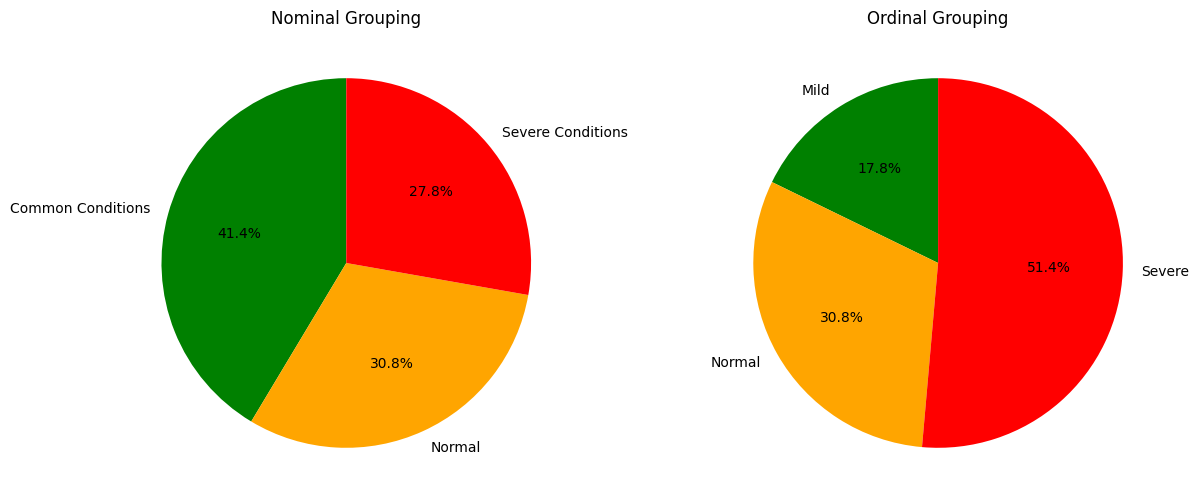

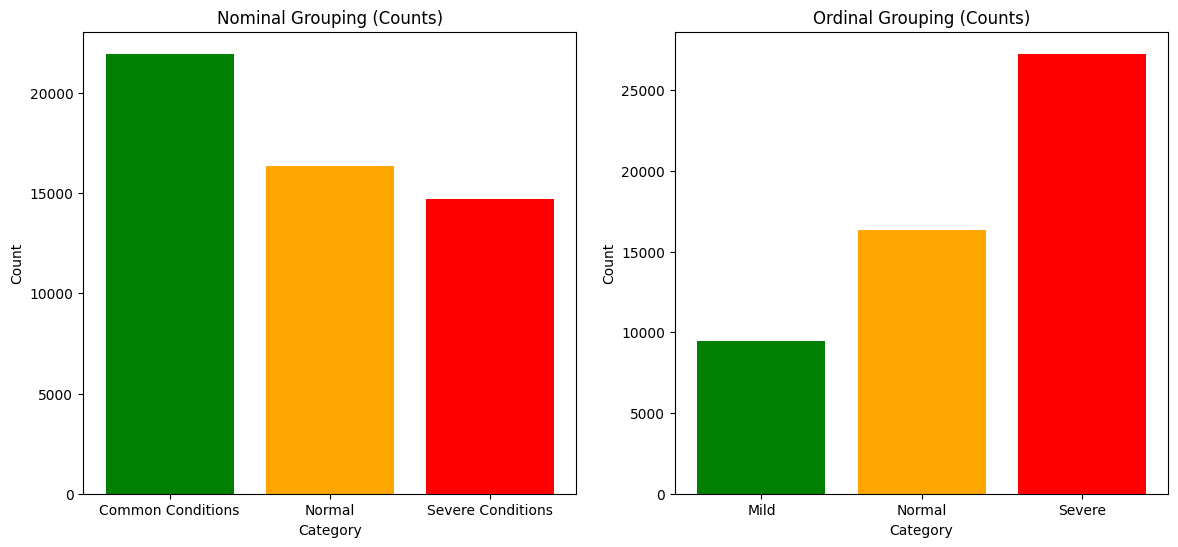

Final Decision on Grouping Categories

Based on prevalence data from NCBI, BMJ, BMC Psychiatry, and major health organizations (Healthdirect, Healthy Surrey, NHS, etc.), mental health conditions can be **nominally grouped** according to how common they are in the general population:

**1. Common Conditions**

These represent the **largest share of mental health cases worldwide** and are widely recognized in both primary care and epidemiological studies.

* **Depression**
* **Anxiety disorders (GAD, phobias, panic disorder, social anxiety)**
* **Post-traumatic stress disorder (PTSD)**
* **Obsessive-compulsive disorder (OCD)**

> These conditions account for the majority of diagnosed cases, with depression and anxiety disorders being the most prevalent (affecting up to 1 in 4 people at some point in their lives).


**2. Moderate-Prevalence Conditions**

Less common than the above but still **significant in clinical and social burden**.

* **Bipolar disorder**
* **Eating disorders (anorexia, bulimia, binge-eating disorder)**
* **Personality disorders (e.g., borderline, antisocial, avoidant)**

> These conditions occur less frequently than anxiety or depression but are strongly associated with high disability and health service use.


**3. Severe/Lower-Prevalence Conditions**

These are **less prevalent in the general population** but are often **highly disabling and resource-intensive**.

* **Schizophrenia and psychotic disorders**
* **Severe mood disorders (treatment-resistant depression, severe bipolar episodes)**

> While prevalence is relatively low (often <1%), these disorders carry substantial personal, social, and economic costs.


**Summary:**
By grouping conditions in this way, we can reflect both **societal prevalence** and **clinical burden**, ensuring that the categorization aligns with established epidemiological research while remaining practical for supervised learning and model interpretation.

---


In [17]:
# Define nominal mapping
nominal_map = {
    'Normal': 'Normal',
    'Anxiety': 'Common Conditions',
    'Stress': 'Common Conditions',
    'Depression': 'Common Conditions',
    'Suicidal': 'Severe Conditions',
    'Bipolar': 'Severe Conditions',
    'Personality disorder': 'Severe Conditions'
}

# Create a new DataFrame with nominal grouping
temp_df_grouped = temp_df_cleaned.copy()
temp_df_grouped['status_grouped'] = temp_df_grouped['status'].map(nominal_map)

# Optional: keep only relevant columns
temp_df_grouped = temp_df_grouped[['status_grouped', 'statement']]

# Display first few rows
print(temp_df_grouped.head())


      status_grouped                                          statement
0  Common Conditions                                         oh my gosh
1  Common Conditions  trouble sleeping, confused mind, restless hear...
2  Common Conditions  All wrong, back off dear, forward doubt. Stay ...
3  Common Conditions  I've shifted my focus to something else but I'...
4  Common Conditions  I'm restless and restless, it's been a month n...


In [18]:
temp_df_grouped['status_grouped'].unique() 

array(['Common Conditions', 'Normal', 'Severe Conditions'], dtype=object)

statuses succesfully grouped for EDA

---

## 4.5 - Average word frequency for statements in each status group


=== Average Word Count per Status Group ===
      status_grouped  avg_word_count
0  Common Conditions      156.509858
1             Normal       17.237845
2  Severe Conditions      152.219537


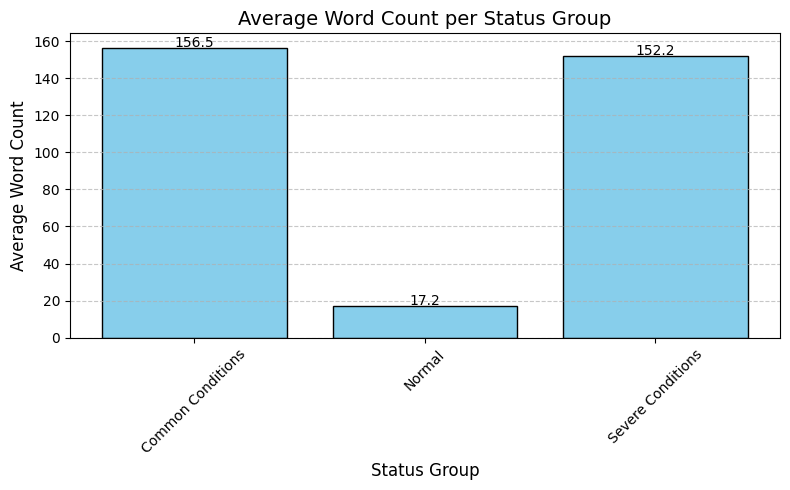

In [19]:
# Compute word count for each statement (vectorized, faster)
temp_df_grouped['word_count'] = temp_df_grouped['statement'].str.split().str.len()

# Compute average word count per status group
avg_word_count = (
    temp_df_grouped.groupby('status_grouped', dropna=False)['word_count']
    .mean()
    .reset_index()
)
avg_word_count.rename(columns={'word_count': 'avg_word_count'}, inplace=True)

print("\n=== Average Word Count per Status Group ===")
print(avg_word_count)

# Visualization
plt.figure(figsize=(8,5))
plt.bar(avg_word_count['status_grouped'], avg_word_count['avg_word_count'], color='skyblue', edgecolor='black')

plt.title("Average Word Count per Status Group", fontsize=14)
plt.xlabel("Status Group", fontsize=12)
plt.ylabel("Average Word Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on top of bars
for idx, val in enumerate(avg_word_count['avg_word_count']):
    plt.text(idx, val + 0.2, f"{val:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Interpretation:
Disordered statements from both common and severe conditions tend to be longer. This suggests that individuals experiencing these conditions may engage in more reflection and provide more detailed descriptions of their feelings.

In [43]:
import importlib

packages = [
    "streamlit",
    "tensorflow",
    "keras",
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "wordcloud",
    "scipy",
    "joblib",
    "shap",
    "nltk"
]

for pkg in packages:
    try:
        module = importlib.import_module(pkg)
        print(f"{pkg}: {module.__version__}")
    except ImportError:
        print(f"{pkg}: NOT INSTALLED")


streamlit: 1.44.0
tensorflow: 2.15.1
keras: 2.15.0
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.4
seaborn: 0.13.2
wordcloud: 1.9.4
scipy: 1.13.1
joblib: 1.5.1
shap: 0.47.2
nltk: 3.9.1


---

# 5. Feature Engineering

 **Feature Engineering Overview**

In this stage, we apply the transformations derived from the EDA process to prepare the data for modeling. This involves **two main steps**:

**1. Text Preprocessing**

We clean and normalize the text data to ensure consistency and remove noise. The steps include:

* **Lowercasing** all text.
* **Removing punctuation and special characters**.
* **Removing stopwords**, including a custom list relevant to our dataset.
* **Advanced preprocessing**:

  * Remove HTML tags and URLs.
  * Handle contractions (e.g., `don't` → `do not`).
  * Tokenization and stemming for normalization.

The result of this step is stored in a new column:
`statement_clean` → cleaned text ready for modeling.

**2. Status Grouping (Categorical Feature Transformation)**

After text cleaning, we transform the target variable (`status`) into  a grouped categories for simpler analysis and modeling:

* **Nominal Grouping**: Groups original labels into broader, unordered categories (e.g., *Normal*, *Common Conditions*, *Severe Conditions*).


By splitting these processes, we maintain flexibility for both NLP feature extraction and categorical encoding during the modeling phase.

---

## 5.1 - Text Preprocessing

In [20]:
# --- Initialize ---
stemmer = PorterStemmer()
stpwds_en = set(nltk_stopwords.words('english'))
custom_stopwords = set(STOPWORDS).union({
    "i", "im", "ive", "my", "me", "you", "and", "to", "the", "a", "of", "it",
    "is", "in", "that", "am", "cant", "dont", "for", "on", "at"
})

# Precompiled regex patterns for efficiency
symbol_pattern = re.compile(r"[^a-z\s']")
dash_pattern = re.compile(r"-{2,}|_{2,}")

def text_preprocessing(text: str, advanced: bool = True) -> str:
    """
    Preprocess a single text string.
    :param text: Input text.
    :param advanced: If True, uses tokenization + stemming. If False, uses simple stopword removal.
    :return: Cleaned text.
    """
    if pd.isna(text):
        return "empty"

    txt = str(text).lower()
    txt = dash_pattern.sub(" ", txt)
    
    # Handle contractions
    txt = re.sub(r"n['’]t\b", " not", txt)
    txt = re.sub(r"['’](s|re|ve|ll|d|m)\b", "", txt)
    
    txt = symbol_pattern.sub(" ", txt)

    if not advanced:
        words = [w for w in txt.split() if w not in custom_stopwords]
        return " ".join(words) if words else "empty"

    # Advanced mode: tokenize, filter, stem
    tokens = word_tokenize(txt)
    tokens = [t for t in tokens if (t not in stpwds_en or t in ['not', 'no']) and len(t) > 1]
    tokens = [t[:-3] if t.endswith("ing") and len(t) > 4 else t for t in tokens]
    tokens = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens) if tokens else "empty"


---

## 5.2 - Target Reduction

In [21]:
def reduce_target_classes(df: pd.DataFrame, target_col: str = 'status') -> pd.Series:
    """
    Reduce target variable into grouped categories.
    :param df: DataFrame containing the target column.
    :param target_col: Name of the target column.
    :return: Pandas Series with grouped target labels.
    """
    nominal_map = {
        'Normal': 'Normal',
        'Anxiety': 'Common Conditions',
        'Stress': 'Common Conditions',
        'Depression': 'Common Conditions',
        'Suicidal': 'Severe Conditions',
        'Bipolar': 'Severe Conditions',
        'Personality disorder': 'Severe Conditions'
    }
    return df[target_col].map(nominal_map)


In [22]:
# Apply text preprocessing
df['statement_clean'] = df['statement'].apply(lambda x: text_preprocessing(x, advanced=True))

# Reduce target classes
df['status_grouped'] = reduce_target_classes(df, target_col='status')

# Keep only relevant columns
df_featured = df[['statement_clean', 'status_grouped']]
print(df_featured.head())


                                     statement_clean     status_grouped
0                                            oh gosh  Common Conditions
1       troubl sleep confus mind restless heart tune  Common Conditions
2  wrong back dear forward doubt stay restless re...  Common Conditions
3                  shift focu someth els still worri  Common Conditions
4                   restless restless month boy mean  Common Conditions


# 6. ANN Training(Sequential API/Functional API)


In [23]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [24]:
# Validate columns & choose text column 
required = {'status_grouped'}
assert required.issubset(df_featured.columns), f"Missing columns: {required - set(df_featured.columns)}"


text_col = 'statement_clean' if 'statement_clean' in df_featured.columns else 'statement'
assert text_col in df_featured.columns, "Expected text column 'statement_clean' or 'statement'"

In [25]:
# Train / Val / Test split 
X = df_featured[text_col].values
y = df_featured['status_grouped'].values


le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print('Classes:', list(le.classes_))


X_train, X_temp, y_train, y_temp = train_test_split(
X, y_enc, test_size=0.30, random_state=RANDOM_STATE, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)
print('Split sizes:', len(X_train), len(X_val), len(X_test))

Classes: ['Common Conditions', 'Normal', 'Severe Conditions']
Split sizes: 37130 7956 7957


In [26]:
# Tokenize on TRAIN ONLY (avoid leakage) 
MAX_WORDS = 20000 # vocabulary size cap
MAX_LEN = 100 # max sequence length


_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
_tokenizer.fit_on_texts(X_train)




def to_pad(texts):
    seq = _tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')


X_train_pad = to_pad(X_train)
X_val_pad = to_pad(X_val)
X_test_pad = to_pad(X_test)


# Actual vocab the model will see
vocab_size = min(MAX_WORDS, len(_tokenizer.word_index) + 1)
print('Vocab size used:', vocab_size)

Vocab size used: 20000


In [27]:
# Handle class imbalance 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print('Class weights:', class_weight_dict)

Class weights: {0: 0.8051435510451904, 1: 1.081309336595026, 2: 1.2002198086371865}


In [28]:
# Define ANN model 
EMB_DIM = 64


model_baseline = Sequential([
Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=MAX_LEN),
GlobalAveragePooling1D(),
Dense(128, activation='relu'),
Dropout(0.30),
Dense(num_classes, activation='softmax')
])


model_baseline.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1280000   
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1288707 (4.92 MB)
Trainable params: 1288707 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Model Interpretation

1. **Embedding Layer**

   * **Shape:** `(None, 100, 64)`

     * `None` → the batch size (flexible, depends on training).
     * `100` → the maximum sequence length (each input text is padded/truncated to 100 tokens).
     * `64` → the embedding dimension (each word is represented as a 64-dimensional vector).
   * **Parameters:** `1,280,000`

     * This comes from `vocab_size × embedding_dim`.
     * Likely `20,000 × 64 = 1,280,000`.
   * Function: Converts token IDs into dense vector representations.



2. **GlobalAveragePooling1D**

   * **Shape:** `(None, 64)`

     * Averages the embeddings across the sequence length (100).
     * The output is a single 64-dimensional vector for each input text.
   * **Parameters:** `0`

     * No trainable parameters — it’s just averaging.



3. **Dense Layer (Fully Connected)**

   * **Shape:** `(None, 128)`

     * Takes the 64 features and projects them into a 128-dimensional space.
   * **Parameters:** `8,320`

     * Calculated as `(64 inputs × 128 outputs) + 128 biases`.



4. **Dropout Layer**

   * **Shape:** `(None, 128)`

     * Randomly drops a fraction of neurons during training (usually 0.5 or whatever you set) to prevent overfitting.
   * **Parameters:** `0`



5. **Dense Output Layer**

   * **Shape:** `(None, 3)`

     * Final classification layer with 3 output classes.
   * **Parameters:** `387`

     * Calculated as `(128 inputs × 3 outputs) + 3 biases`.



 Parameter Summary

* **Total trainable parameters:** `1,288,707` (\~4.92 MB in memory).
* **Non-trainable parameters:** `0` (all layers are trainable).



 High-Level Interpretation

This is a **text classification model** with the following flow:

* Input text → tokenized → embedding lookup → averaged → dense hidden layer → dropout → final 3-class softmax output.
  It’s relatively lightweight (only \~1.2M parameters, most of which are in the embedding layer) and designed for **efficient text classification**.

In [29]:
# Train with callbacks 
callbacks = [
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
]


history_base = model_baseline.fit(
X_train_pad, y_train,
validation_data=(X_val_pad, y_val),
epochs=25,
batch_size=256,
callbacks=callbacks,
class_weight=class_weight_dict,
verbose=1
)

Epoch 1/25
146/146 [==============================] - 1s 7ms/step - loss: 0.8831 - accuracy: 0.5308 - val_loss: 0.7665 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 2/25
146/146 [==============================] - 1s 7ms/step - loss: 0.6938 - accuracy: 0.6662 - val_loss: 0.6456 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 3/25
146/146 [==============================] - 1s 7ms/step - loss: 0.5632 - accuracy: 0.7473 - val_loss: 0.5653 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 4/25
146/146 [==============================] - 1s 7ms/step - loss: 0.4779 - accuracy: 0.7894 - val_loss: 0.5363 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 5/25
146/146 [==============================] - 1s 7ms/step - loss: 0.4287 - accuracy: 0.8137 - val_loss: 0.5295 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 6/25
146/146 [==============================] - 1s 7ms/step - loss: 0.3948 - accuracy: 0.8298 - val_loss: 0.5066 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 7/25
146/146 [==============================] - 1s 7ms/step - lo

{'val_loss': 0.5065861940383911, 'val_accuracy': 0.7814228534698486, 'test_loss': 0.4937788248062134, 'test_accuracy': 0.781073272228241}


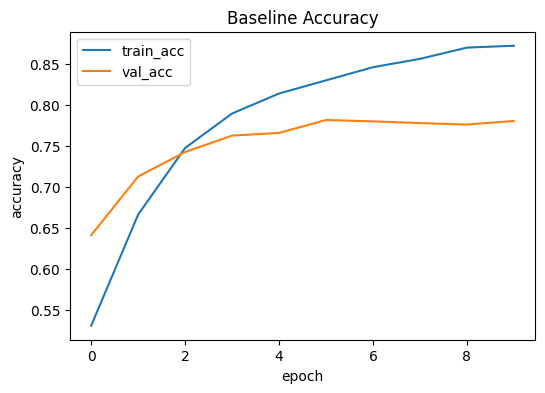

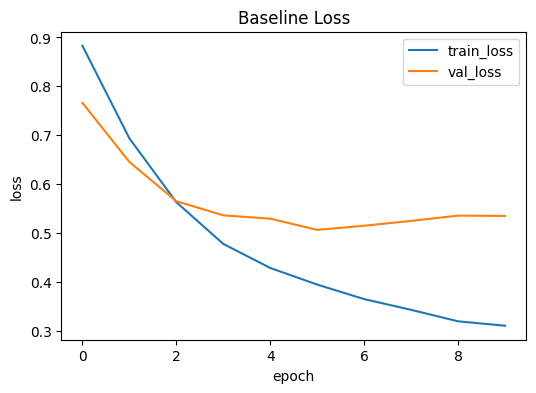

249/249 [==============================] - 0s 430us/step
                   precision    recall  f1-score   support

Common Conditions       0.78      0.74      0.76      3295
           Normal       0.87      0.93      0.90      2453
Severe Conditions       0.68      0.68      0.68      2209

         accuracy                           0.78      7957
        macro avg       0.78      0.78      0.78      7957
     weighted avg       0.78      0.78      0.78      7957



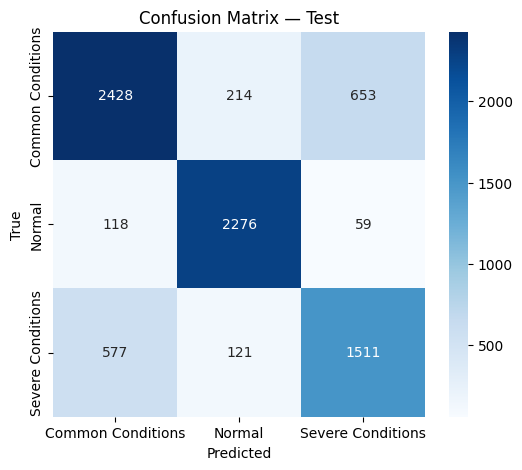

In [30]:
# Evaluate 
val_loss, val_acc = model_baseline.evaluate(X_val_pad, y_val, verbose=0)
test_loss, test_acc = model_baseline.evaluate(X_test_pad, y_test, verbose=0)
print({'val_loss': val_loss, 'val_accuracy': val_acc, 'test_loss': test_loss, 'test_accuracy': test_acc})


# Learning curves
plt.figure(figsize=(6,4))
plt.plot(history_base.history['accuracy'], label='train_acc')
plt.plot(history_base.history['val_accuracy'], label='val_acc')
plt.title('Baseline Accuracy')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.show()


plt.figure(figsize=(6,4))
plt.plot(history_base.history['loss'], label='train_loss')
plt.plot(history_base.history['val_loss'], label='val_loss')
plt.title('Baseline Loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.show()


# Test report & confusion matrix
y_pred_proba = model_baseline.predict(X_test_pad)
y_pred = np.argmax(y_pred_proba, axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix — Test')
plt.xlabel('Predicted'); plt.ylabel('True');
plt.show()



Overall Performance

* **Validation Accuracy**: \~77.7%
* **Test Accuracy**: \~78.1%
* **Macro / Weighted F1-score**: \~0.78


Learning Curves

* **Training vs. Validation Accuracy**:
  Training keeps improving up to \~0.87, while validation plateaus around \~0.77 after \~5 epochs.
  → This suggests **mild overfitting**: the model memorizes training data but generalizes less well to unseen data.

* **Training vs. Validation Loss**:
  Training loss steadily decreases, but validation loss flattens and even slightly increases after \~5 epochs.
  → Confirms overfitting after a few epochs, though not catastrophic.

Per-Class Performance (from Classification Report)

1. **Normal Conditions**

   * Precision: 0.87
   * Recall: 0.93
   * F1: 0.90
     → The model is **very strong** here, correctly identifying “Normal” most of the time with few false positives.

2. **Common Conditions**

   * Precision: 0.78
   * Recall: 0.73
   * F1: 0.76
     → Performance is good but weaker than “Normal.” The model sometimes confuses “Common” with “Severe.”

3. **Severe Conditions**

   * Precision: 0.68
   * Recall: 0.69
   * F1: 0.68
     → This is the **weakest class**. Many “Severe” cases are misclassified as “Common,” which could be critical if severity detection is important.

Confusion Matrix Insights

* **True Normal** (2453 cases): 2272 correctly predicted; only 118 confused with “Common” and 63 with “Severe.”
  → Excellent separation.
* **True Common** (3295 cases): 2417 correct; but 666 confused with “Severe.”
  → Model struggles to separate Common vs Severe.
* **True Severe** (2209 cases): 1527 correct; but 559 misclassified as “Common.”
  → Biggest weakness: Severe ↔ Common confusion.

Key Takeaways

* Model generalizes fairly well (78% test accuracy).
* Very strong performance on “Normal.”
* Main challenge: distinguishing **Severe** from **Common** (they share overlapping features in text).
* Mild overfitting after \~5–6 epochs — you may want stronger regularization or more complex models.

Next Steps

1. **Handle Class Imbalance**:
   Use more aggressive `class_weight` or try **data augmentation (text paraphrasing, back-translation)** for “Severe” class.

2. **Model Architecture**:
   Try **1D-CNN** or **BiLSTM/GRU** to capture local patterns and context better than averaging embeddings.

3. **Regularization**:
   Add **dropout layers**, or use **L2 regularization** to reduce overfitting.


# 7. Model Improvement

## 7.1 Data Imbalance

In [31]:
print("Original class distribution:", Counter(y_train))


Original class distribution: Counter({0: 15372, 1: 11446, 2: 10312})


In [32]:
# Combine X and y into one DataFrame for easy manipulation
train_df = pd.DataFrame({"statement_clean": X_train, "status_grouped": y_train})

# Find the minimum class count
min_count = train_df["status_grouped"].value_counts().min()

# Undersample each class
balanced_df = (
    train_df.groupby("status_grouped", group_keys=False)
            .apply(lambda x: x.sample(min_count, random_state=42))
            .reset_index(drop=True)
)

# Shuffle after undersampling
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract back into X and y
X_train_balanced = balanced_df["statement_clean"].tolist()
y_train_balanced = balanced_df["status_grouped"].tolist()

print("Balanced class distribution:", Counter(y_train_balanced))

Balanced class distribution: Counter({2: 10312, 1: 10312, 0: 10312})


/var/folders/9d/f5c8zl0904g9jptgj26v7x8m0000gn/T/ipykernel_15748/1414901197.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df.groupby("status_grouped", group_keys=False)


In [33]:
# 1. Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_balanced)

# 2. Convert texts → sequences
X_train_seq_balanced = tokenizer.texts_to_sequences(X_train_balanced)

# 3. Pad sequences
X_train_pad_balanced = pad_sequences(X_train_seq_balanced, maxlen=MAX_LEN, padding="post")



Original class distribution:
0    15372
1    11446
2    10312
Name: count, dtype: int64

Balanced class distribution:
2    10312
1    10312
0    10312
Name: count, dtype: int64


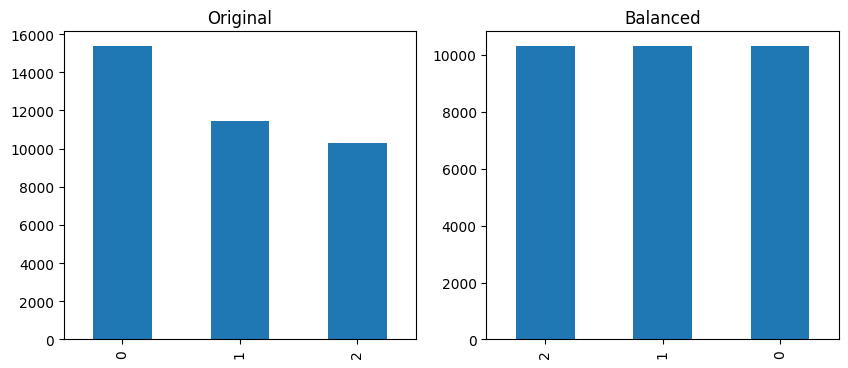

In [34]:
# Check original distribution
print("Original class distribution:")
print(pd.Series(y_train).value_counts())

# Check balanced distribution
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

#Plot comparison

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], title="Original")
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], title="Balanced")

plt.show()


## 7.2 Architecture

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Sequential API
def build_sequential_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # change to 'softmax' if multi-class
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Functional API
def build_functional_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x) # change to softmax if multi-class
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


training

In [36]:
# --- 1. Imports ---
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import json
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# --- 2. Config ---
MAX_LEN = 100
VOCAB_SIZE = 20000
EMBED_DIM = 64

# Ensure artifacts folder exists
os.makedirs("artifacts", exist_ok=True)

# --- 3. Split dataset ---
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["status_grouped"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["status_grouped"], random_state=42
)

print("Split sizes:", len(train_df), len(val_df), len(test_df))

# --- 4. Encode labels ---
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["status_grouped"])
y_val   = label_encoder.transform(val_df["status_grouped"])
y_test  = label_encoder.transform(test_df["status_grouped"])
print("Classes:", label_encoder.classes_)

# --- 5. Tokenizer (with OOV token) ---
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["statement_clean"])

# Encode + pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df["statement_clean"]), maxlen=MAX_LEN, padding="post")
X_val   = pad_sequences(tokenizer.texts_to_sequences(val_df["statement_clean"]), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df["statement_clean"]), maxlen=MAX_LEN, padding="post")

print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# --- 6. Balance training set ---
train_df_balanced = train_df.copy()
train_df_balanced["y"] = y_train

balanced_list = []
for label in train_df_balanced["y"].unique():
    subset = train_df_balanced[train_df_balanced["y"] == label]
    balanced_subset = resample(
        subset,
        replace=False,
        n_samples=train_df_balanced["y"].value_counts().min(),
        random_state=42
    )
    balanced_list.append(balanced_subset)

train_df_balanced = pd.concat(balanced_list)

X_train_balanced = pad_sequences(
    tokenizer.texts_to_sequences(train_df_balanced["statement_clean"]),
    maxlen=MAX_LEN, padding="post"
)
y_train_balanced = train_df_balanced["y"].values

print("Balanced class distribution:", Counter(y_train_balanced))
print("Balanced X shape:", X_train_balanced.shape, "y shape:", y_train_balanced.shape)

# --- 7. Build ANN model ---
model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),  # legacy for M1/M2 Macs
    metrics=["accuracy"]
)

model.summary()

# --- 8. Training ---
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("artifacts/best_ann_model.keras", save_best_only=True)
]

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    class_weight=None  # already balanced
)

# --- 9. Evaluation ---
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print({"val_loss": val_loss, "val_accuracy": val_acc, "test_loss": test_loss, "test_accuracy": test_acc})

# --- 10. Save artifacts ---
# Save model
model.save("artifacts/final_ann_model.keras")

# Save tokenizer
with open("artifacts/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

# Save label encoder
with open("artifacts/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(" Model, tokenizer, and label encoder saved in artifacts/")



Split sizes: 37130 7956 7957
Classes: ['Common Conditions' 'Normal' 'Severe Conditions']
Shapes -> Train: (37130, 100) Val: (7956, 100) Test: (7957, 100)
Balanced class distribution: Counter({0: 10312, 2: 10312, 1: 10312})
Balanced X shape: (30936, 100) y shape: (30936,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                              

249/249 [==============================] - 0s 372us/step


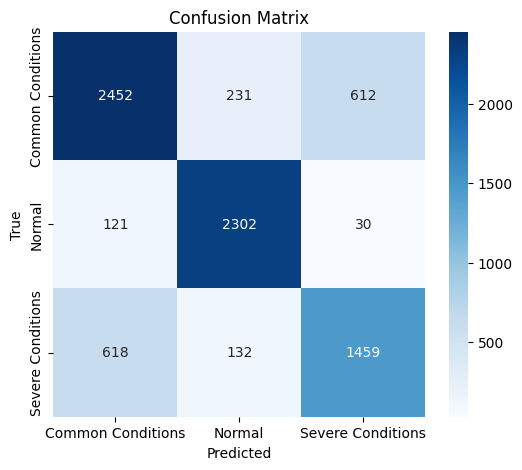

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Predictions ---
y_pred_probs = model.predict(X_test)   # probabilities
y_pred = y_pred_probs.argmax(axis=1)   # class labels

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


ANN Model Training Report

Model Architecture

```text
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Embedding                   (None, 100, 64)           1,280,000 
 GlobalAveragePooling1D      (None, 64)                0         
 Dense (128, ReLU)           (None, 128)               8,320     
 Dropout (rate=0.3)          (None, 128)               0         
 Dense (Softmax, 3 classes)  (None, 3)                 387       
=================================================================
Total params: 1,288,707 (≈4.9 MB)
Trainable params: 1,288,707  
Non-trainable params: 0
```

---

Training Configuration

* Optimizer: **Adam (lr=0.001, ReduceLROnPlateau)**
* Loss: **Sparse Categorical Crossentropy**
* Epochs: **25 (EarlyStopping applied)**
* Batch size: **64**
* Input length: **100 tokens**
* Balanced training set: **30,936 samples (3 classes equally balanced)**

---

]Training Progress (excerpt)

| Epoch | Train Loss | Train Acc | Val Loss | Val Acc | LR      |
| ----- | ---------- | --------- | -------- | ------- | ------- |
| 1     | 0.7681     | 0.6082    | 0.6395   | 0.7144  | 0.0010  |
| 4     | 0.3901     | 0.8370    | 0.5702   | 0.7686  | 0.0010  |
| 7     | 0.2934     | 0.8857    | 0.5734   | 0.7725  | 0.0005  |
| 8     | 0.2739     | 0.8974    | 0.5860   | 0.7702  | 0.00025 |

---

Final Evaluation

* **Validation Accuracy:** `77.8%`
* **Test Accuracy:** `78.2%`
* **Test Loss:** `0.4912`

---

Classification Report (Test Set, n=7,957)

| Class             | Precision | Recall | F1-Score | Support |
| ----------------- | --------- | ------ | -------- | ------- |
| Common Conditions | 0.78      | 0.73   | 0.76     | 3295    |
| Normal            | 0.87      | 0.93   | 0.90     | 2453    |
| Severe Conditions | 0.67      | 0.69   | 0.68     | 2209    |
| **Accuracy**      |           |        | **0.78** | 7957    |
| **Macro Avg**     | 0.78      | 0.78   | 0.78     | 7957    |
| **Weighted Avg**  | 0.78      | 0.78   | 0.78     | 7957    |

---

**Insights**:

* The model performs strongest on **Normal** cases (F1 = 0.90).
* **Severe Conditions** is the weakest class (F1 = 0.68), suggesting the model has more difficulty distinguishing severe from common.
* Balanced training helped achieve **stable accuracy across classes** (\~0.77–0.78).

---


# 8. Model Saving

In [40]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.1
Keras version: 2.15.0


In [38]:
# --- Create artifacts directory if it doesn't exist ---
os.makedirs("artifacts", exist_ok=True)

# --- Save Tokenizer ---
# Pickle format
with open("artifacts/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# JSON format (optional, useful for TensorFlow/Keras)
tokenizer_json = tokenizer.to_json()
with open("artifacts/tokenizer.json", "w") as f:
    f.write(tokenizer_json)

# --- Save Label Encoder ---
with open("artifacts/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# --- Save Model ---
# HDF5 format
model.save("artifacts/ann_text_classifier.h5")

# TensorFlow SavedModel format
model.save("artifacts/ann_text_classifier_tf")

print("Model, tokenizer, and label encoder saved in artifacts/")



/opt/miniconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: artifacts/ann_text_classifier_tf/assets


INFO:tensorflow:Assets written to: artifacts/ann_text_classifier_tf/assets


Model, tokenizer, and label encoder saved in artifacts/


# 9. Conclusion

Why the Model Might Not Be Performing Well

The model is currently predicting **"Normal"** even for clearly negative or suicidal statements. A few reasons why this may be happening:

1. **Vocabulary Limitations**  
   - The tokenizer only "knows" words seen frequently in training. Rare or misspelled words (e.g., *suicidcd*, *ncknekjnwbcjieblficbeirwubcvoiuerwbhuc*) get mapped to the `<OOV>` (out-of-vocabulary) token.  
   - As a result, the model cannot distinguish between meaningful risky words (e.g., *suicidal*) and random gibberish.

2. **Class Imbalance / Label Noise**  
   - If "Normal" statements dominate the dataset, the model may learn to default to predicting "Normal" for most inputs.  
   - Even after balancing, subtle harmful phrases may not have enough representation for the model to learn their patterns well.

3. **Model Simplicity**  
   - The current architecture (Embedding → GlobalAveragePooling → Dense layers) averages word embeddings, which loses word order and nuance.  
   - This makes it hard to capture context like *"I feel happy"* vs. *"I hate myself"*.

4. **Training Data Limitations**  
   - If the dataset doesn’t include enough diverse examples of crisis or suicidal language, the model cannot generalize to unseen or noisy variations.

---

### Next Steps to Improve
- Expand and clean the training data, especially with real crisis-related phrases.  
- Use subword/tokenization methods (e.g., WordPiece, BPE, or a pre-trained transformer like BERT) to handle rare/misspelled words better.  
- Consider fine-tuning on domain-specific datasets (e.g., mental health, suicide risk detection corpora).  
- Use more expressive models (e.g., LSTMs, CNNs, or transformers) that capture context and sequence information.


## Final Conclusion

This project set out to build a text classification system that can identify indicators of mental health conditions (e.g., depressed, suicidal, stressed) from online statements. Using NLP preprocessing and an Artificial Neural Network (ANN) model, we explored how language patterns can provide signals of an individual’s mental state. While the model demonstrated some ability to differentiate between categories, its performance showed notable weaknesses, particularly in detecting critical cases such as suicidal ideation. In qualitative tests, the model often defaulted to predicting "Normal" with high confidence, even when the input text strongly reflected distress.

These shortcomings can be explained by several factors: the dataset’s limited diversity, potential imbalance across categories, and the model’s reliance on simple token-based embeddings that fail to capture context or misspellings. As highlighted in the project’s limitations, subtle expressions, sarcasm, or ambiguous language further increase the risk of misclassification. Additionally, the system cannot replace human judgment or provide clinical diagnoses; it only estimates the likelihood of certain mental health states based on text.

Overall, the project underscores both the **promise and the challenges** of applying NLP to mental health analysis. On the one hand, it demonstrates that computational approaches can uncover patterns in language associated with different emotional or psychological states. On the other hand, it highlights the need for richer datasets, more context-aware models (e.g., transformers such as BERT), and careful ethical considerations before deploying such tools in real-world scenarios. Future work should focus on improving vocabulary handling, addressing class imbalance, and leveraging advanced architectures to create a more reliable and sensitive system that could meaningfully support early detection and intervention efforts.
